In [ ]:
############# AT THE START, WE INSTALL PACKAGES WE NEED ###################################

# We use a package that might be new to some of you, called "INLA" 
# This package helps implement Bayesian methods and helps make some of our steps fast/easy to implement
# We will explain it as we go through this code 

############# OPEN R, THEN RUN THE FOLLOWING COMMAND ###################

install.packages("INLA",repos=c(getOption("repos"),INLA="https://inla.r-inla-download.org/R/stable"), dep=TRUE)
install.packages("fmesher", dependencies = TRUE)
install.packages("MatrixModels", type = "source")
install.packages("exactextractr")
install.packages("sn" ,dependencies = TRUE)
packages <- c("terra","dplyr","spdep", "exactextractr", "sf","ggplot2","viridis","sn","fmesher","exactextractr","fields")
package.check <- lapply(packages, FUN = function(x) {
    if (!require(x, character.only = TRUE)) {
        install.packages(x, dependencies = TRUE)
        library(x, character.only = TRUE, quietly=TRUE)
    }
})
Sys.setenv("AWS_DEFAULT_REGION" = 'us-west-2')

# ##### THE FOLLOWING COMMANDS ARE FOR THE INSTALLATION OF PACKAGES ON NASA MAAP #####
# ##### CONDA-FORGE YOUR WAY THROUGH PACKAGES THAT DID NOT INSTALL ##########

conda install conda-forge::r-fmesher
conda install conda-forge::r-exactextractr
conda install conda-forge::r-sn
conda install conda-forge::r-inlabru
conda install conda-forge::r-fields

In [ ]:
############## LOAD PACKAGES ###########

library("fmesher")
library(MatrixModels)
library(Matrix)
library(INLA)
library(inlabru)
library("jpeg")

library(sf)
library(terra)
library(dplyr)
library(spdep)
library(raster)
# library(exactextractr)

library(ggplot2)
library(viridis)
library(stringr)
# library(sn)

In [2]:
NFI <- st_read("/projects/my-private-bucket/Data/NFI_data/Sudan/Sudan_NFI.gpkg")
file_list <- Sys.glob("/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/GEDI_Strata/Sudan_country.gpkg")

Reading layer `biomass_carbon_bysu_20241009_withstrataid' from data source 
  `/projects/my-private-bucket/Data/NFI_data/Sudan/Sudan_NFI.gpkg' 
  using driver `GPKG'
Simple feature collection with 784 features and 9 fields
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: 22.2243 ymin: 9.307635 xmax: 37.53202 ymax: 21.83538
Geodetic CRS:  WGS 84


Reading layer `Sudan_country' from data source 
  `/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/GEDI_Strata/Sudan_country.gpkg' 
  using driver `GPKG'
Simple feature collection with 1 feature and 2 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: 21.84084 ymin: 8.684103 xmax: 38.58349 ymax: 23.13772
Geodetic CRS:  WGS 84


Warning message:
“attribute variables are assumed to be spatially constant throughout all geometries”


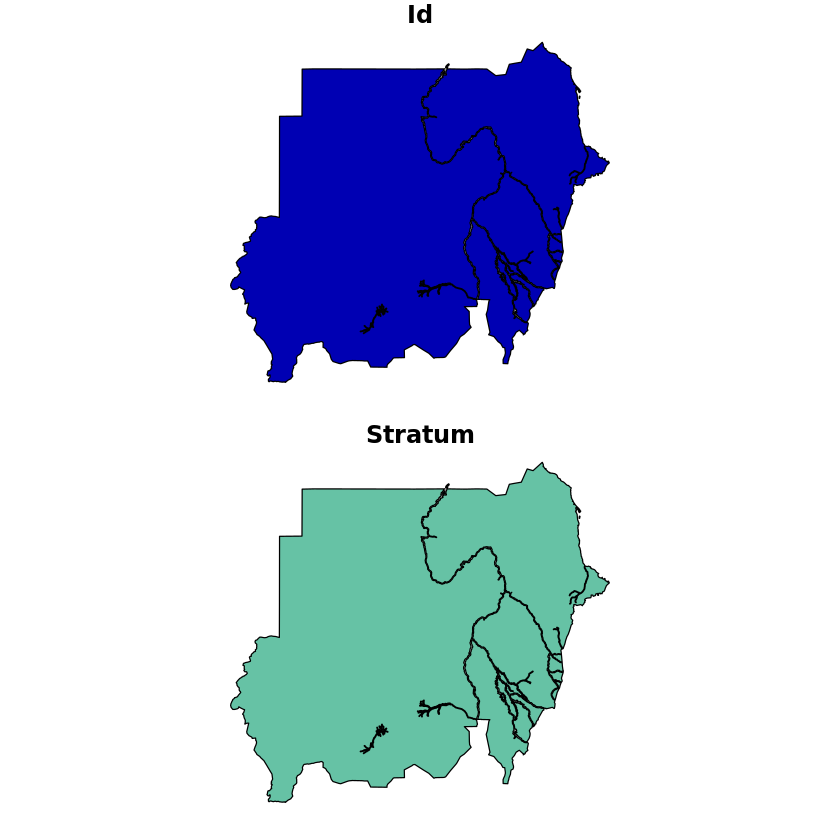

In [3]:
Sudan <- st_read(file_list) 
NFI_subset <- st_intersection(NFI, Sudan)
plot(Sudan)

In [10]:
Grid_set <- function(maps,verbose=FALSE){
    gt <- GridTopology(c(-180 + 5, -60 + 5), c(10, 10), c(36,14))
    grd <- SpatialGrid(gt, proj4string="+init=epsg:4326")
    spix <- as(grd, "SpatialPixels")
    spol <- as(spix, "SpatialPolygons")
}

HANSEN_LIST <- function(tiles,aoi){
    maps_AOImasked_Hansen_masked <- ''
    file_prefixs <- ''
    EMask_folder <- "/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN"
    for (n in 1:length(tiles)) {
        tile <- tiles[n]
        min_x <- bbox(tile)[1, 1]
        max_y <- bbox(tile)[2, 2]
        if (min_x < 0) {
          min_x <- paste0(sprintf('%03i', abs(min_x)),'W')
        } else {
          min_x <- paste0(sprintf('%03i', min_x),'E')
        }
        if (max_y < 0) {
          max_y <- paste0(sprintf('%02i', abs(max_y)),'S')
        } else {
          max_y <- paste0(sprintf('%02i', max_y),'N')
        }
        file_prefix <- paste0(EMask_folder,'/','treecover2010_', max_y,'_', min_x,'.tif')
        file_prefixs[n] <- file_prefix
    }

    file_prefixs <- file_prefixs[file_prefixs != ""]
    return(file_prefixs)
}

CCI_LIST <- function(tiles,aoi){
    maps_AOImasked_Hansen_masked <- ''
    file_prefixs <- ''
    EMask_folder <- "/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN"
    for (n in 1:length(tiles)) {
        tile <- tiles[n]
        min_x <- bbox(tile)[1, 1]
        max_y <- bbox(tile)[2, 2]
        if (min_x < 0) {
          min_x <- paste0('W',sprintf('%03i', abs(min_x)))
        } else {
          min_x <- paste0('E',sprintf('%03i', min_x))
        }
        if (max_y < 0) {
          max_y <- paste0('S',sprintf('%02i', abs(max_y)))
        } else {
          max_y <- paste0('N',sprintf('%02i', max_y))
        }
        file_prefix <- paste0(EMask_folder,'/',max_y,'', min_x,'_ESACCI-BIOMASS-L4-AGB-MERGED-100m-2021-fv5.0.tif')
        # file_prefix <- paste0(EMask_folder,'/2020_',max_y,'_', min_x,'.tif')
        file_prefixs[n] <- file_prefix
    }

    file_prefixs <- file_prefixs[file_prefixs != ""]
    return(file_prefixs)
}

Grid_tiles <- Grid_set()

intersecting <- (st_intersects(st_as_sf(Sudan),st_as_sf(Grid_tiles)))[[1]]
nrow_tiles <- intersecting
if (length(intersecting) == 0) {
    stop('no intersecting CCI Biomass tiles found')
} else {tiles <- (Grid_tiles[nrow_tiles,])}

# HANSEN_LIST <- HANSEN_LIST(tiles=tiles,aoi=Sudan)
# if (length(HANSEN_LIST) > 1){ 
#     r_lst <- lapply(HANSEN_LIST, rast)
#     coll <- sprc(r_lst)
#     HANSEN <- terra::mosaic(coll, fun = "mean")
# } else {HANSEN <- rast(HANSEN_LIST)} #%>% project("epsg:6933")
# names(HANSEN) <- c("TC")
# HANSEN.plot = terra::extract(HANSEN, NFI)
# writeRaster(HANSEN, "/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/GMB_Test/HANSEN_TC_Sudan.tif",gdal=c("COMPRESS=LZW"), overwrite=TRUE)
rm(HANSEN)

CCI_LIST <- CCI_LIST(tiles=tiles,aoi=Sudan)
if (length(CCI_LIST) > 1){ 
    r_lst <- lapply(CCI_LIST, rast)
    coll <- sprc(r_lst)
    CCI <- terra::mosaic(coll, fun = "mean")
} else {CCI <- rast(CCI_LIST)} #%>% project("epsg:6933")
names(CCI) <- c("AGB")
CCI.plot = terra::extract(CCI, NFI)
NFI['CCI'] <- CCI.plot$AGB
writeRaster(CCI, "/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/GMB_Test/CCI_AGB_Sudan.tif", gdal=c("COMPRESS=LZW"), overwrite=TRUE)
# writeRaster(CCI, "/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/GMB_Test/POTAPOV_Height_Sudan.tif", gdal=c("COMPRESS=LZW"), overwrite=TRUE)
rm(CCI)

Warning message in rm(HANSEN):
“object 'HANSEN' not found”


In [7]:
NFI['HEIGHT'] <- CCI.plot$AGB
NFI['TC'] <- HANSEN.plot$TC
NFI['CCI'] <- CCI.plot$AGB

[1] "SU"                 "Longitude"          "Latitude"          
 [4] "AG_Biomass..Mg.ha." "BG_Biomass..Mg.ha." "AG_Carbon..Mg.ha." 
 [7] "BG_Carbon..Mg.ha."  "Strata"             "nfifrlgrid_Strata" 
[10] "geom"               "HEIGHT"             "TC"                
[13] "CCI"

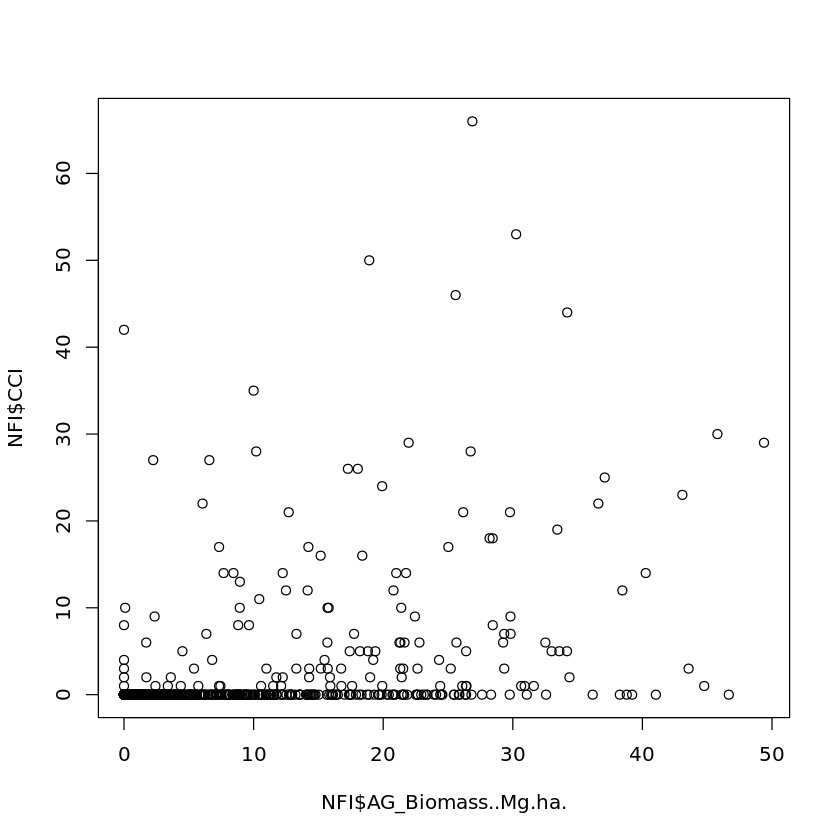

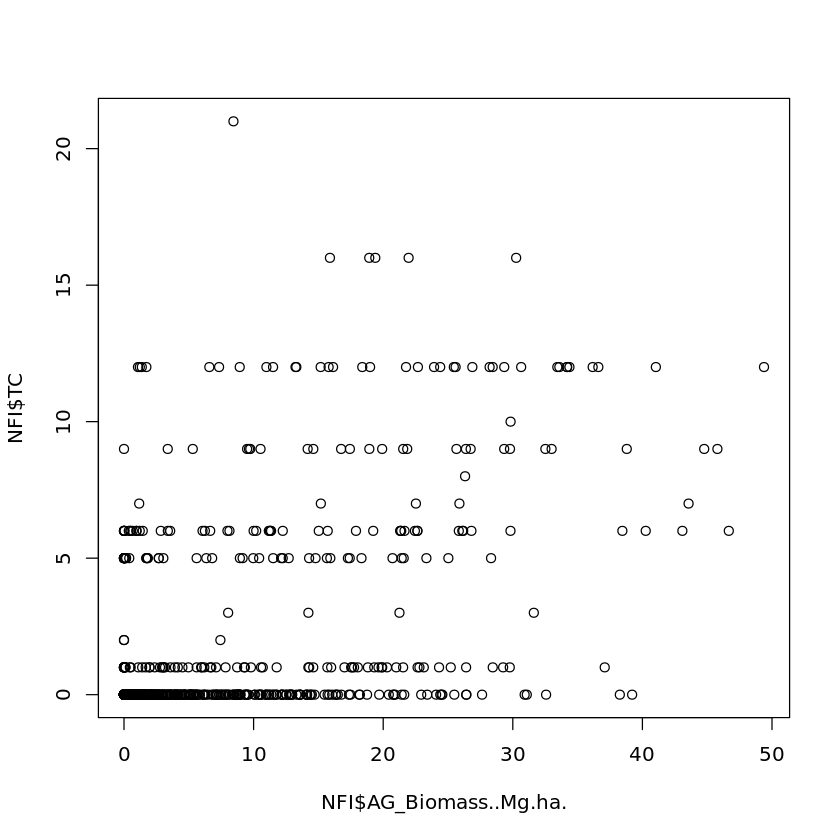

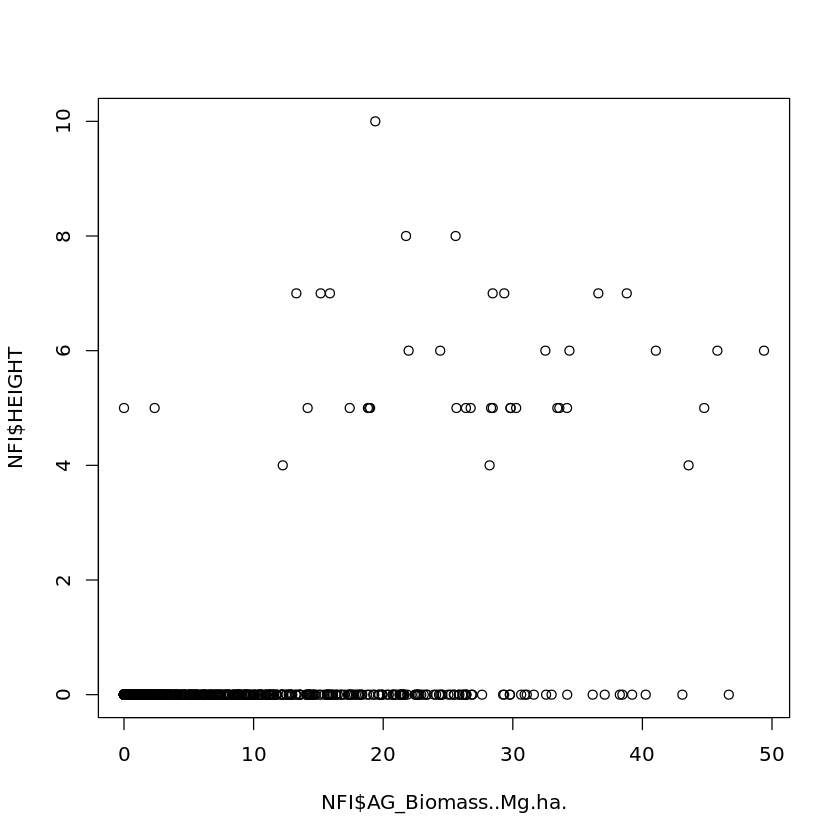

In [12]:
# HANSEN.plot$TC[CCI.plot$AGB == 0] = NA
# CCI.plot$AGB[CCI.plot$AGB == 0] = NA
# NFI$AG_Biomass..Mg.ha.[is.na(HANSEN.plot$TC)] = NA
# write.csv(NFI %>% st_drop_geometry(),"/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/GMB_Test/NFI_and_COVARIATES.csv",row.names=FALSE) #Save the data

colnames(NFI)
plot(NFI$AG_Biomass..Mg.ha.,NFI$CCI)
plot(NFI$AG_Biomass..Mg.ha.,NFI$TC)
plot(NFI$AG_Biomass..Mg.ha.,NFI$HEIGHT)

write.csv(NFI %>% st_drop_geometry(),"/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/GMB_Test/NFI_and_COVARIATES.csv",row.names=FALSE) #Save the data

In [ ]:
for (file in file_list) {

    file_tif_mean = str_replace_all(file,".gpkg", "_AGBD_mean.tif")
    file_tif_SD = str_replace_all(file,".gpkg", "_AGBD_VAR.tif")
    if (!file.exists(file_tif_mean)) {

        Sudan <- st_read(file) # %>% st_transform(crs=6933)
        GEDI <- st_intersection(L4A_Sudan, Sudan)
        if (nrow(GEDI) > 0) {
        
            ###############################################################
            ###############################################################
            Grid_set <- function(maps,verbose=FALSE){
                gt <- GridTopology(c(-180 + 5, -60 + 5), c(10, 10), c(36,14))
                grd <- SpatialGrid(gt, proj4string="+init=epsg:4326")
                spix <- as(grd, "SpatialPixels")
                spol <- as(spix, "SpatialPolygons")
            }
            
            HANSEN_LIST <- function(tiles,aoi){
                maps_AOImasked_Hansen_masked <- ''
                file_prefixs <- ''
                EMask_folder <- "/projects/shared-buckets/leitoldv/gfc_data"
                for (n in 1:length(tiles)) {
                    tile <- tiles[n]
                    min_x <- bbox(tile)[1, 1]
                    max_y <- bbox(tile)[2, 2]
                    if (min_x < 0) {
                      min_x <- paste0(sprintf('%03i', abs(min_x)),'W')
                    } else {
                      min_x <- paste0(sprintf('%03i', min_x),'E')
                    }
                    if (max_y < 0) {
                      max_y <- paste0(sprintf('%02i', abs(max_y)),'S')
                    } else {
                      max_y <- paste0(sprintf('%02i', max_y),'N')
                    }
                    file_prefix <- paste0(EMask_folder,'/','Hansen_GFC-2020-v1.8_treecover2020_', max_y,'_', min_x,'.tif')
                    file_prefixs[n] <- file_prefix
                }
            
                file_prefixs <- file_prefixs[file_prefixs != ""]
                return(file_prefixs)
            }

            CCI_LIST <- function(tiles,aoi){
                maps_AOImasked_Hansen_masked <- ''
                file_prefixs <- ''
                EMask_folder <- "/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/GMB_Test"
                for (n in 1:length(tiles)) {
                    tile <- tiles[n]
                    min_x <- bbox(tile)[1, 1]
                    max_y <- bbox(tile)[2, 2]
                    if (min_x < 0) {
                      min_x <- paste0('W',sprintf('%03i', abs(min_x)))
                    } else {
                      min_x <- paste0('E',sprintf('%03i', min_x))
                    }
                    if (max_y < 0) {
                      max_y <- paste0('S',sprintf('%02i', abs(max_y)))
                    } else {
                      max_y <- paste0('N',sprintf('%02i', max_y))
                    }
                    file_prefix <- paste0(EMask_folder,'/',max_y,'', min_x,'_ESACCI-BIOMASS-L4-AGB-MERGED-100m-2021-fv5.0.tif')
                    file_prefixs[n] <- file_prefix
                }
            
                file_prefixs <- file_prefixs[file_prefixs != ""]
                return(file_prefixs)
            }

            
            ###############################################################
            ###############################################################
            #### GEDI <- st_read(file_L4A)# %>% st_transform(crs=6933)
            Grid_tiles <- Grid_set()
            
            intersecting <- (st_intersects(st_as_sf(Sudan),st_as_sf(Grid_tiles)))[[1]]
            nrow_tiles <- intersecting
            if (length(intersecting) == 0) {
                stop('no intersecting CCI Biomass tiles found')
            } else {tiles <- (Grid_tiles[nrow_tiles,])}
            
            HANSEN_LIST <- HANSEN_LIST(tiles=tiles,aoi=Sudan)
            if (length(HANSEN_LIST) > 1){ 
                r_lst <- lapply(HANSEN_LIST, rast)
                coll <- sprc(r_lst)
                HANSEN <- terra::mosaic(coll, fun = "mean")
            } else {HANSEN <- rast(HANSEN_LIST)} #%>% project("epsg:6933")
            names(HANSEN) <- c("TC")
            HANSEN.plot = terra::extract(HANSEN, GEDI)

            CCI_LIST <- CCI_LIST(tiles=tiles,aoi=Sudan)
            if (length(CCI_LIST) > 1){ 
                r_lst <- lapply(CCI_LIST, rast)
                coll <- sprc(r_lst)
                CCI <- terra::mosaic(coll, fun = "mean")
            } else {CCI <- rast(CCI_LIST)} #%>% project("epsg:6933")
            names(CCI) <- c("AGB")
            CCI.plot = terra::extract(CCI, GEDI)

            HANSEN.plot$TC[CCI.plot$AGB == 0] = NA
            CCI.plot$AGB[CCI.plot$AGB == 0] = NA
            GEDI$AGBD_1[is.na(HANSEN.plot$TC)] = NA
            
            GEDI$HANSEN <- HANSEN.plot$TC
            GEDI$CCI <- CCI.plot$AGB
            GEDI <- GEDI %>% st_transform(crs=6933)
            coords <- as.data.frame(st_coordinates(GEDI))
            GEDI$X <- coords$X
            GEDI$Y <- coords$Y
            write.csv(GEDI %>% st_drop_geometry(),"/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/GMB_Test/GEDIL4A_and_COVARIATES.csv",row.names=FALSE) #Save the data
            
            Sudan <- Sudan %>% st_transform(crs=6933)
            
            DATA = read.csv("/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/GMB_Test/GEDIL4A_and_COVARIATES.csv")
            DATA$gedi.agbd <- (DATA$AGBD_1)
            DATA$HANSEN.tc <- (DATA$HANSEN)
            DATA$CCI.agb <- (DATA$CCI)
            
            dt = sort(sample(nrow(DATA), nrow(DATA)*.9))
            DATA <- DATA[dt,]
            write.csv(DATA,"/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/GMB_Test/DATA.csv",row.names=FALSE) #Save the data
            DATA_TEST <- DATA[-dt,]
            write.csv(DATA_TEST,"/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/GMB_Test/DATA_TEST.csv",row.names=FALSE) #Save the data
            
            ###############################################################
            ###############################################################
            
            DATA <- read.csv("/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/GMB_Test/DATA.csv")
            factor <- (1/4)
            DATA$gedi.agbd <- (DATA$gedi.agbd)^factor
            
            loc.plot <- data.matrix(as.data.frame(cbind(DATA$X,DATA$Y)))
            gedi.agbd <- DATA$gedi.agbd
            HANSEN.tc <- DATA$HANSEN.tc
            CCI.agb <- DATA$CCI.agb
            
            max.edge = 500
            Sudan.buffer = st_buffer(Sudan, dist = max.edge*5) # We also make a 5 km buffer around Sudan to prevent boundary effects.
            mesh = inla.mesh.2d(boundary = list(as(Sudan, "Spatial"), as(Sudan.buffer, "Spatial")), max.edge = c(max.edge, 3*max.edge), cutoff = 2*max.edge/3, offset = c(max.edge, 5*max.edge)) 
            k = mesh$n ### This is the resulting number of vertices
            loc.plot <- data.matrix(loc.plot) #In case loc.plot is a df rather than matrix, use "loc.plot <- data.matrix(loc.plot)"
            n.plot = nrow(loc.plot)
            A.plot = inla.spde.make.A(mesh = mesh, loc = loc.plot) # make a new projector matrix with the new mesh and the same plot locations. 
            spde.alpha = inla.spde2.pcmatern(mesh, 
                                             prior.range = c(30000, 0.01), # This says the probability that the range is LESS than 30 km is 0.01
                                             prior.sigma = c(60, 0.01)) # This says the probability that the sd is GREATER than 60 Mg/ha is 0.01
            
            # Priors for the varying coefficient beta_tilde
            spde.beta = inla.spde2.pcmatern(mesh, 
                                            prior.range = c(30000, 0.01), # Same interpretations here
                                            prior.sigma = c(1, 0.5)) # This says the probability that the sd is GREATER than 1 is 0.5

            # Priors for the varying coefficient eta_tilde
            spde.eta = inla.spde2.pcmatern(mesh, 
                                            prior.range = c(30000, 0.01), # Same interpretations here
                                            prior.sigma = c(1, 0.5)) # This says the probability that the sd is GREATER than 1 is 0.5
            
            ### Construct our formula #####
            formula = agbd ~
              -1 + # removes the automatic intercept so you can include your named intercept
              intercept + 
              HANSEN +
              CCI + 
              f(alpha.spat, model = spde.alpha) + 
              f(beta.spat, model = spde.beta) +  
              f(eta.spat, model = spde.eta)
            ## Arrange our data so we can supply it to INLA to input in the formula above #####
            stack = inla.stack(data = list(agbd = gedi.agbd),
                               A = list(1, 
                                        1, 
                                        1,
                                        A.plot, 
                                        Diagonal(x = HANSEN.tc)%*%A.plot,
                                        Diagonal(x = CCI.agb)%*%A.plot),# 
                               effects = list(
                                 intercept = rep(1, n.plot),
                                 HANSEN = HANSEN.tc,
                                 CCI = CCI.agb,
                                 alpha.spat = 1:k, 
                                 beta.spat = 1:k,
                                 eta.spat = 1:k)
                              )
            model_fit = inla(formula = formula, # Provide the formula
                             family = 'gaussian', # We assume our data follows a Gaussian generalized linear model (GLM)
                             data = inla.stack.data(stack), # These line and the one below are simply how we feed INLA the stack.
                             control.predictor = list(A = inla.stack.A(stack)),
                             control.compute = list(config = T, dic = T, waic = T, cpo = T),
                             control.inla = list(int.strategy = "eb"), # EB just fixes the hyperparameters at their maximum posterior (like maximum likelihood, but accounting for priors) values. The other methods manually integrate across the range of possible values.
                             verbose = TRUE)
            summary(model_fit)
            save(model_fit, file = "/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/GMB_Test/INLA_model_fit.RData")
            hist(model_fit$cpo$pit, breaks = 20) 
            
            ###############################################################
            ###############################################################
            
            load("/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/GMB_Test/INLA_model_fit.RData")
            Buffer_Sudan <- st_buffer(Sudan, -4500) 
            grid_to_predict = st_make_grid(Buffer_Sudan, cellsize = c(100,100), what = "centers") %>% st_as_sf()
            grid = as.data.frame(grid_to_predict %>% st_coordinates())
            grid_to_predict_4326 <- grid_to_predict %>% st_transform(crs=4326)
            HANSEN.pred = terra::extract(HANSEN, grid_to_predict_4326)
            HANSEN.pred <- HANSEN.pred$TC
            CCI.pred = terra::extract(CCI, grid_to_predict_4326)
            CCI.pred <- CCI.pred$AGB
            
            loc.plot_T <- data.matrix(as.data.frame(cbind(grid$X,grid$Y)))
            
            samples = inla.posterior.sample(n = 100, result = model_fit) # Draw posterior samples from our model fit 
            A.pred = inla.spde.make.A(mesh = mesh, loc = loc.plot_T) # Make a new projector matrix with the same mesh, but new plot locations 
            
            # Our model function
            pred_fun = function(...){
              drop(intercept + 
                HANSEN.pred*HANSEN +
                CCI.pred*CCI +
                A.pred%*%alpha.spat[1:k] +   
                Diagonal(x = HANSEN.pred)%*%A.pred%*%beta.spat[1:k] + 
                Diagonal(x = CCI.pred)%*%A.pred%*%eta.spat[1:k]) + 
                rnorm(nrow(A.pred), sd = sqrt(1/theta[1])) 
            }
            
            # Generate prediction samples, i.e. ask INLA to use the prediction function and samples to make predictions at our testing plot locations. 
            pred.samples = (inla.posterior.sample.eval(fun = pred_fun,samples = samples)) #
            
            # Model mean AGBD expectations and SD's at the grid locations
            pred.mu = Matrix::rowMeans(pred.samples^(1/factor),na.rm=TRUE)
            pred.sd = apply(pred.samples^(1/factor), 1, var)
            options(repr.plot.width=5, repr.plot.height=5)
            
            ####################### And here are some maps to see what the predictions look like at the plot locations ##########
            ggplot() + coord_sf(crs = 6933) + 
                       geom_point(aes(x = loc.plot_T[,1], y = loc.plot_T[,2], col = pred.mu),size=1) +  # make a map to see plot locations and the AGBD values at each location
                       scale_color_viridis(limits = c(0, 420)) + xlab("X location of testing plots") + ylab("Y location of testing plots") + ggtitle("GMB-predicted AGBD at 10% testing locations") + theme(plot.title = element_text(color="red", size=14, face="bold.italic"))
            
            xyz_data <- data.frame(x = loc.plot_T[,1], y = loc.plot_T[,2], z = pred.mu)
            PREDICTIONS <- rasterFromXYZ(xyz_data)
            crs(PREDICTIONS) <- CRS("+init=epsg:6933")
            writeRaster(PREDICTIONS, file_tif_mean, format = "GTiff", overwrite=TRUE)
            
            xyz_data <- data.frame(x = loc.plot_T[,1], y = loc.plot_T[,2], z = pred.sd)
            PREDICTIONS <- rasterFromXYZ(xyz_data)
            crs(PREDICTIONS) <- CRS("+init=epsg:6933")
            writeRaster(PREDICTIONS, file_tif_SD, format = "GTiff", overwrite=TRUE)
        }
    }
}

Reading layer `fid_118' from data source 
  `/projects/my-public-bucket/Data/NASA_CMS_2023/GHANA/GMB_Test/0p5_grid/fid_118.gpkg' 
  using driver `GPKG'
Simple feature collection with 1 feature and 7 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -0.8617972 ymin: 5.104933 xmax: -0.7063654 ymax: 5.161778
Geodetic CRS:  WGS 84


Warning message:
“attribute variables are assumed to be spatially constant throughout all geometries”


Reading layer `fid_144' from data source 
  `/projects/my-public-bucket/Data/NASA_CMS_2023/GHANA/GMB_Test/0p5_grid/fid_144.gpkg' 
  using driver `GPKG'
Simple feature collection with 1 feature and 7 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -0.06179717 ymin: 7.861778 xmax: 0.4382028 ymax: 8.361778
Geodetic CRS:  WGS 84


Warning message:
“attribute variables are assumed to be spatially constant throughout all geometries”


Reading layer `fid_145' from data source  
  `/projects/my-public-bucket/Data/NASA_CMS_2023/GHANA/GMB_Test/0p5_grid/fid_145.gpkg' 
  using driver `GPKG'
Simple feature collection with 1 feature and 7 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -0.06179717 ymin: 7.461778 xmax: 0.4382028 ymax: 7.961778
Geodetic CRS:  WGS 84


Warning message:
“attribute variables are assumed to be spatially constant throughout all geometries”


Reading layer `fid_146' from data source  
  `/projects/my-public-bucket/Data/NASA_CMS_2023/GHANA/GMB_Test/0p5_grid/fid_146.gpkg' 
  using driver `GPKG'
Simple feature collection with 1 feature and 7 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -0.06179717 ymin: 7.061778 xmax: 0.4382028 ymax: 7.561778
Geodetic CRS:  WGS 84


Warning message:
“attribute variables are assumed to be spatially constant throughout all geometries”


Time used:
    Pre = 1.25, Running = 1261, Post = 15.2, Total = 1277 
Fixed effects:
           mean    sd 0.025quant 0.5quant 0.975quant  mode kld
intercept 2.877 6.112     -9.102    2.877     14.856 2.877   0
HANSEN    0.011 1.336     -2.607    0.011      2.630 0.011   0

Random effects:
  Name	  Model
    alpha.spat SPDE2 model
   beta.spat SPDE2 model

Model hyperparameters:
                                            mean       sd 0.025quant 0.5quant
Precision for the Gaussian observations 6.43e-01 1.50e-02   6.11e-01 6.43e-01
Range for alpha.spat                    1.03e+13 6.75e+14   3.46e+03 1.64e+06
Stdev for alpha.spat                    7.48e+08 4.70e+10   6.35e-01 2.48e+02
Range for beta.spat                     5.96e+10 3.45e+12   1.51e+04 4.32e+06
Stdev for beta.spat                     5.61e+03 3.29e+05   1.00e-03 3.91e-01
                                        0.975quant     mode
Precision for the Gaussian observations   6.70e-01    0.647
Range for alpha.spat          

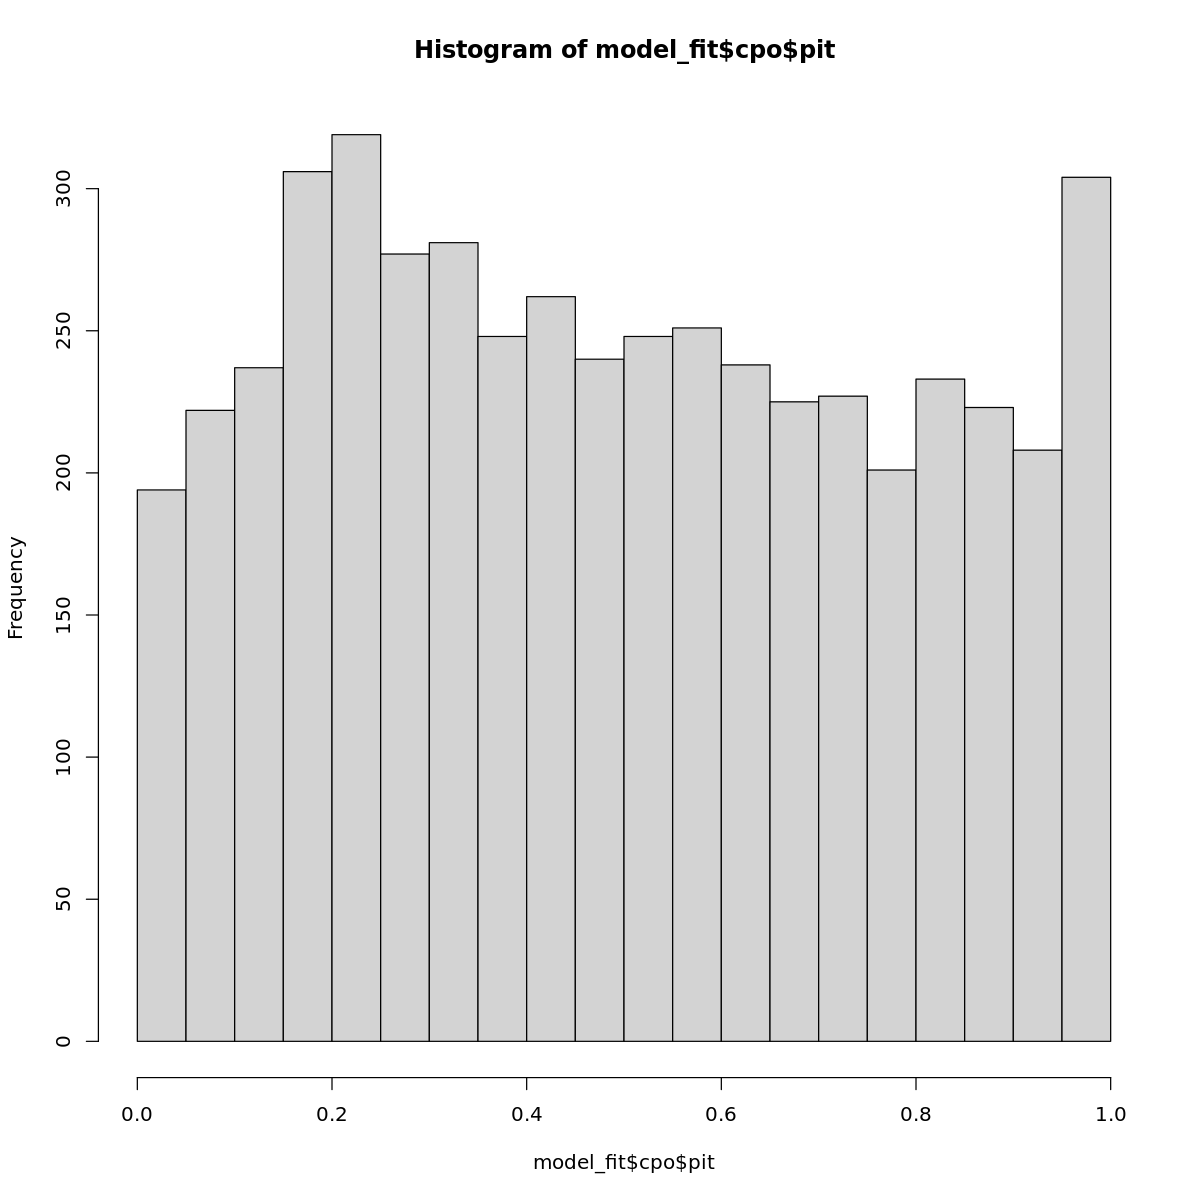

In [43]:
DATA <- read.csv("/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/GMB_Test/DATA.csv")
factor <- (1/3)
DATA$gedi.agbd <- (DATA$gedi.agbd)^factor

loc.plot <- data.matrix(as.data.frame(cbind(DATA$X,DATA$Y)))
gedi.agbd <- DATA$gedi.agbd
HANSEN.tc <- DATA$HANSEN.tc

max.edge = 500
Sudan.buffer = st_buffer(Sudan, dist = max.edge*5) # We also make a 5 km buffer around Sudan to prevent boundary effects.
mesh = inla.mesh.2d(boundary = list(as(Sudan, "Spatial"), as(Sudan.buffer, "Spatial")), max.edge = c(max.edge, 3*max.edge), cutoff = 2*max.edge/3, offset = c(max.edge, 5*max.edge)) 
k = mesh$n ### This is the resulting number of vertices
loc.plot <- data.matrix(loc.plot) #In case loc.plot is a df rather than matrix, use "loc.plot <- data.matrix(loc.plot)"
n.plot = nrow(loc.plot)
A.plot = inla.spde.make.A(mesh = mesh, loc = loc.plot) # make a new projector matrix with the new mesh and the same plot locations. 
spde.alpha = inla.spde2.pcmatern(mesh, 
                                 prior.range = c(30000, 0.01), # This says the probability that the range is LESS than 30 km is 0.01
                                 prior.sigma = c(60, 0.01)) # This says the probability that the sd is GREATER than 60 Mg/ha is 0.01

# Priors for the varying coefficient beta_tilde
spde.beta = inla.spde2.pcmatern(mesh, 
                                prior.range = c(30000, 0.01), # Same interpretations here
                                prior.sigma = c(1, 0.5)) # This says the probability that the sd is GREATER than 1 is 0.5

### Construct our formula #####
formula = agbd ~
  -1 + # removes the automatic intercept so you can include your named intercept
  intercept + 
  HANSEN +
  f(alpha.spat, model = spde.alpha) + 
  f(beta.spat, model = spde.beta) 
## Arrange our data so we can supply it to INLA to input in the formula above #####
stack = inla.stack(data = list(agbd = gedi.agbd),
                   A = list(1, 
                            1, 
                            A.plot, 
                            Diagonal(x = HANSEN.tc)%*%A.plot),# 
                   effects = list(
                     intercept = rep(1, n.plot),
                     HANSEN = HANSEN.tc,
                     alpha.spat = 1:k, 
                     beta.spat = 1:k)
                  )
model_fit = inla(formula = formula, # Provide the formula
                 family = 'gaussian', # We assume our data follows a Gaussian generalized linear model (GLM)
                 data = inla.stack.data(stack), # These line and the one below are simply how we feed INLA the stack.
                 control.predictor = list(A = inla.stack.A(stack)),
                 control.compute = list(config = T, dic = T, waic = T, cpo = T),
                 control.inla = list(int.strategy = "eb"), # EB just fixes the hyperparameters at their maximum posterior (like maximum likelihood, but accounting for priors) values. The other methods manually integrate across the range of possible values.
                 verbose = TRUE)
summary(model_fit)
save(model_fit, file = "/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/GMB_Test/INLA_model_fit.RData")
hist(model_fit$cpo$pit, breaks = 20) 

In [ ]:
load("/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/GMB_Test/INLA_model_fit.RData")
DATA_TEST <- read.csv("/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/GMB_Test/DATA_TEST.csv")
DATA_TEST$gedi.agbd <- (DATA_TEST$gedi.agbd)^factor

loc.plot_T <- data.matrix(as.data.frame(cbind(DATA_TEST$X,DATA_TEST$Y)))
gedi.pred <- (DATA_TEST$gedi.agbd)

grid_to_test <- as.data.frame(loc.plot_T )%>% sf::st_as_sf(coords = c(1,2))
st_crs(grid_to_test) <- 6933

grid_to_test_4326 <- grid_to_test %>% st_transform(crs=4326)
HANSEN.pred = terra::extract(HANSEN, grid_to_test_4326)
HANSEN.pred <- HANSEN.pred$TC

samples = inla.posterior.sample(n = 250, result = model_fit) # Draw posterior samples from our model fit 
A.pred = inla.spde.make.A(mesh = mesh, loc = loc.plot_T) # Make a new projector matrix with the same mesh, but new plot locations 

# Our model function
pred_fun = function(...){
  drop(intercept + 
    HANSEN.pred*HANSEN +
    A.pred%*%alpha.spat[1:k] +   
    Diagonal(x = HANSEN.pred)%*%A.pred%*%beta.spat[1:k]) + 
    rnorm(nrow(A.pred), sd = sqrt(1/theta[1])) 
}

# Generate prediction samples, i.e. ask INLA to use the prediction function and samples to make predictions at our testing plot locations. 
pred.samples = (inla.posterior.sample.eval(fun = pred_fun,samples = samples)) #

# Model mean AGBD expectations and SD's at the grid locations
pred.mu = Matrix::rowMeans(pred.samples)
pred.sd = apply(pred.samples, 1, sd)

OUTPUT <- do.call(rbind, Map(data.frame, PRED=pred.mu, NFI=gedi.pred, PRED.SD=pred.sd, RES=gedi.pred-pred.mu))
ggplot(data = OUTPUT, aes(x = NFI,y = PRED))+ geom_point() + geom_abline(size=0.5,linetype=2,col="red",lwd=1.5) + theme_bw() + xlim(0,10) + ylim(0,10) + xlab("sqrt of NFI AGBD") + ylab("GMB model predictions") + ggtitle("sqrt(NFI AGBD) vs. GMB predictions at 10% testing locations") + theme(plot.title = element_text(color="red", size=12, face="bold.italic"))

################## COMPUTE A HEURISTIC FOR ACCURACY, LIKE AN R2 VALUE #############
 # Computing a value like an R^2 for our testing locations will give us an idea of prediction error at unobserved locations

# Let's also square the model expectations because we applied a sqrt transformation at the start
pred.mu = Matrix::rowMeans(pred.samples^(1/factor))
pred.sd = apply(pred.samples^(1/factor), 1, sd)

OUTPUT <- do.call(rbind, Map(data.frame, PRED=pred.mu, NFI=gedi.pred^(1/factor), PRED.SD=pred.sd, RES=gedi.pred^(1/factor)-pred.mu))
options(repr.plot.width=8, repr.plot.height=6)
ggplot(data = OUTPUT, aes(x = NFI,y = PRED))+ geom_point()  + geom_abline(size=0.5,linetype=2,col="red",lwd=1.5) + theme_bw() + xlim(0,300) + ylim(0,300) + xlab("NFI AGBD") + ylab("GMB model predictions squared") + ggtitle("NFI AGBD vs. square of GMB predictions at 10% testing locations") + theme(plot.title = element_text(color="red", size=12, face="bold.italic"),axis.text=element_text(size=20))
        
####################### And here are some maps to see what the predictions look like at the plot locations ##########
options(repr.plot.width=6, repr.plot.height=6)
ggplot() + coord_sf(crs = 6933) + 
           geom_point(aes(x = loc.plot_T[,1], y = loc.plot_T[,2], col = gedi.pred^(1/factor)),size=0.5) +  # make a map to see plot locations and the AGBD values at each location
           scale_color_viridis(limits = c(0, 300)) + xlab("X location of testing plots") + ylab("Y location of testing plots") + ggtitle("NFI-estimated AGBD at 10% testing locations") + theme(plot.title = element_text(color="red", size=14, face="bold.italic"))
           # geom_sf(data = Deforestation,col="red",fill=NA,lwd=1)# add our fake deforestation sites

ggplot() + coord_sf(crs = 6933) + 
           geom_point(aes(x = loc.plot_T[,1], y = loc.plot_T[,2], col = pred.mu),size=0.5) +  # make a map to see plot locations and the AGBD values at each location
           scale_color_viridis(limits = c(0, 300)) + xlab("X location of testing plots") + ylab("Y location of testing plots") + ggtitle("GMB-predicted AGBD at 10% testing locations") + theme(plot.title = element_text(color="red", size=14, face="bold.italic"))
           # geom_sf(data = Deforestation,col="red",fill=NA,lwd=1)# add our fake deforestation sites

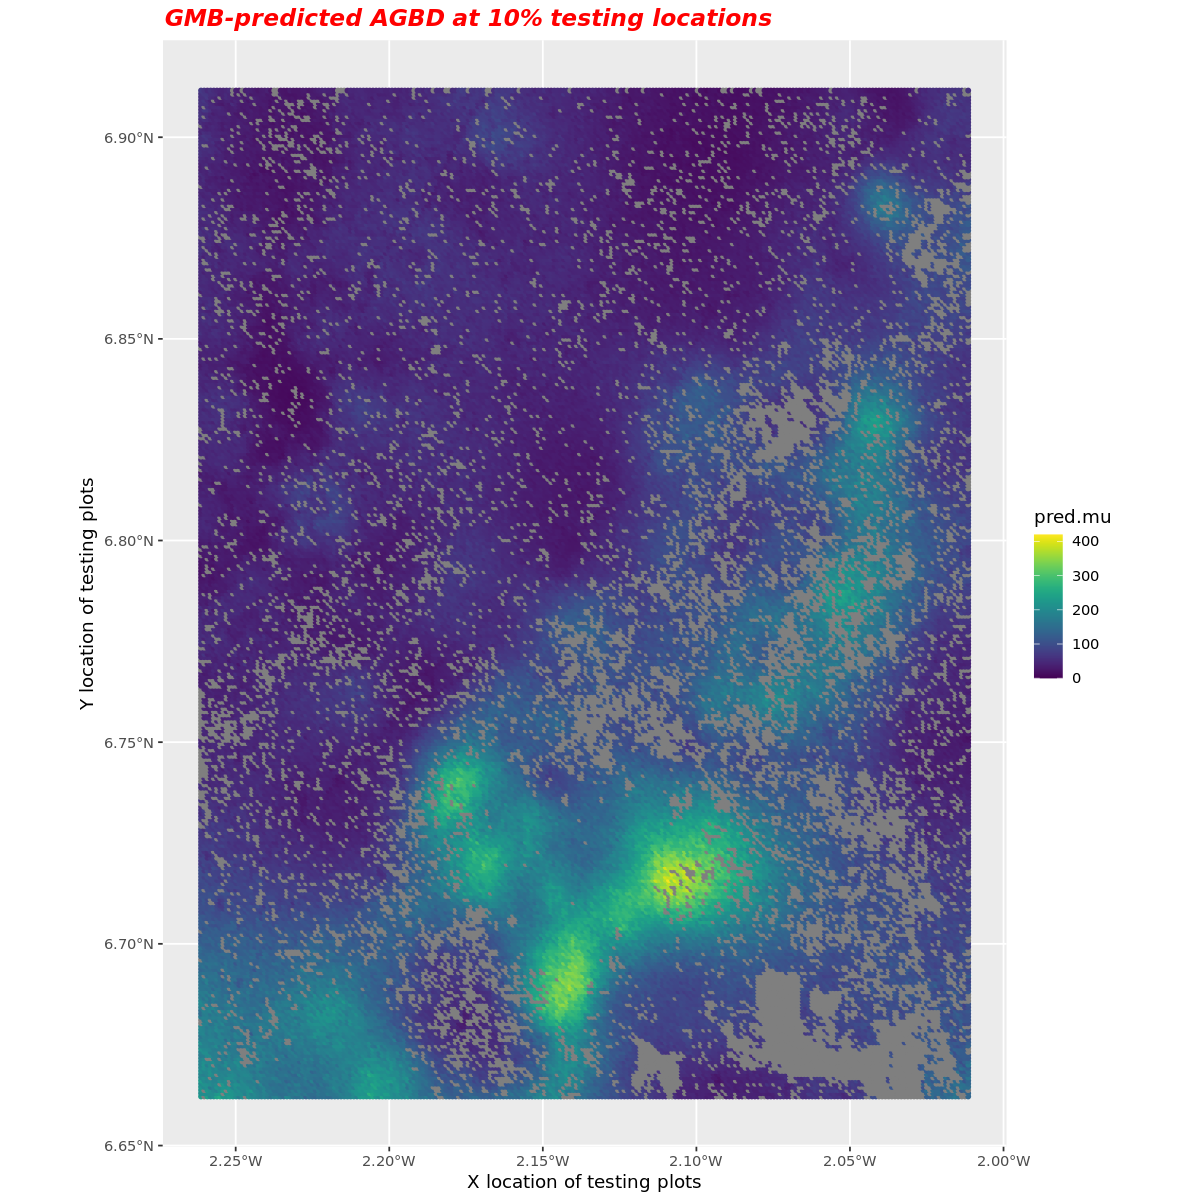

In [45]:
load("/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/GMB_Test/INLA_model_fit.RData")
grid_to_predict = st_make_grid(Sudan, cellsize = c(100,100), what = "centers") %>% st_as_sf()
grid = as.data.frame(grid_to_predict %>% st_coordinates())
grid_to_predict_4326 <- grid_to_predict %>% st_transform(crs=4326)
HANSEN.pred = terra::extract(HANSEN, grid_to_predict_4326)
HANSEN.pred <- HANSEN.pred$TC

loc.plot_T <- data.matrix(as.data.frame(cbind(grid$X,grid$Y)))

samples = inla.posterior.sample(n = 200, result = model_fit) # Draw posterior samples from our model fit 
A.pred = inla.spde.make.A(mesh = mesh, loc = loc.plot_T) # Make a new projector matrix with the same mesh, but new plot locations 

# Our model function
pred_fun = function(...){
  drop(intercept + 
    HANSEN.pred*HANSEN +
    A.pred%*%alpha.spat[1:k] +   
    Diagonal(x = HANSEN.pred)%*%A.pred%*%beta.spat[1:k]) + 
    rnorm(nrow(A.pred), sd = sqrt(1/theta[1])) 
}

# Generate prediction samples, i.e. ask INLA to use the prediction function and samples to make predictions at our testing plot locations. 
pred.samples = (inla.posterior.sample.eval(fun = pred_fun,samples = samples)) #

# Model mean AGBD expectations and SD's at the grid locations
pred.mu = Matrix::rowMeans(pred.samples^(1/factor))
pred.sd = apply(pred.samples^(1/factor), 1, sd)
options(repr.plot.width=10, repr.plot.height=10)

####################### And here are some maps to see what the predictions look like at the plot locations ##########
ggplot() + coord_sf(crs = 6933) + 
           geom_point(aes(x = loc.plot_T[,1], y = loc.plot_T[,2], col = pred.mu),size=1) +  # make a map to see plot locations and the AGBD values at each location
           scale_color_viridis(limits = c(0, 420)) + xlab("X location of testing plots") + ylab("Y location of testing plots") + ggtitle("GMB-predicted AGBD at 10% testing locations") + theme(plot.title = element_text(color="red", size=14, face="bold.italic"))

xyz_data <- data.frame(x = loc.plot_T[,1], y = loc.plot_T[,2], z = pred.mu)
PREDICTIONS <- rasterFromXYZ(xyz_data)
crs(PREDICTIONS) <- CRS("+init=epsg:6933")
writeRaster(PREDICTIONS, "/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/GMB_Test/fid_122_mean.tif", format = "GTiff", overwrite=TRUE)

xyz_data <- data.frame(x = loc.plot_T[,1], y = loc.plot_T[,2], z = pred.sd)
PREDICTIONS <- rasterFromXYZ(xyz_data)
crs(PREDICTIONS) <- CRS("+init=epsg:6933")
writeRaster(PREDICTIONS, "/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/GMB_Test/fid_122_SD.tif", format = "GTiff", overwrite=TRUE)

In [42]:
HANSEN_LIST

[1] "/projects/shared-buckets/leitoldv/gfc_data/Hansen_GFC-2020-v1.8_treecover2020_10N_010W.tif"

In [39]:
min(pred.mu,na.rm=TRUE)

[1] 6.22719

In [107]:
GEDI <- st_read("/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/GMB_Test/L4A_Extent_Large_2.gpkg")# %>% st_transform(crs=6933)
HANSEN <- rast("/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/WA_Hansen_6933.tif") #%>% project("epsg:6933")

Reading layer `gha_l4a_predict_af_coarse_fit_af_sqrt_sqrt_snowdon_1' from data source `/projects/my-public-bucket/Data/NASA_CMS_2023/GHANA/GMB_Test/L4A_Extent_Large_2.gpkg' 
  using driver `GPKG'
Integer64 values larger than 9.0072e+15 lost significance after conversion to double;
use argument int64_as_string = TRUE to import them lossless, as character
Simple feature collection with 64493 features and 21 fields
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: -3.094233 ymin: 5.622852 xmax: -2.274768 ymax: 6.175983
Geodetic CRS:  WGS 84


In [96]:
# writeRaster(HANSEN, filename="/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/GMB_Test/Hansen_1_6933_C.tif", overwrite=TRUE, gdal=c("COMPRESS=LZW"))

ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'object' in selecting a method for function 'summary': invalid type (NULL) for variable 'GEDI$HANSEN'


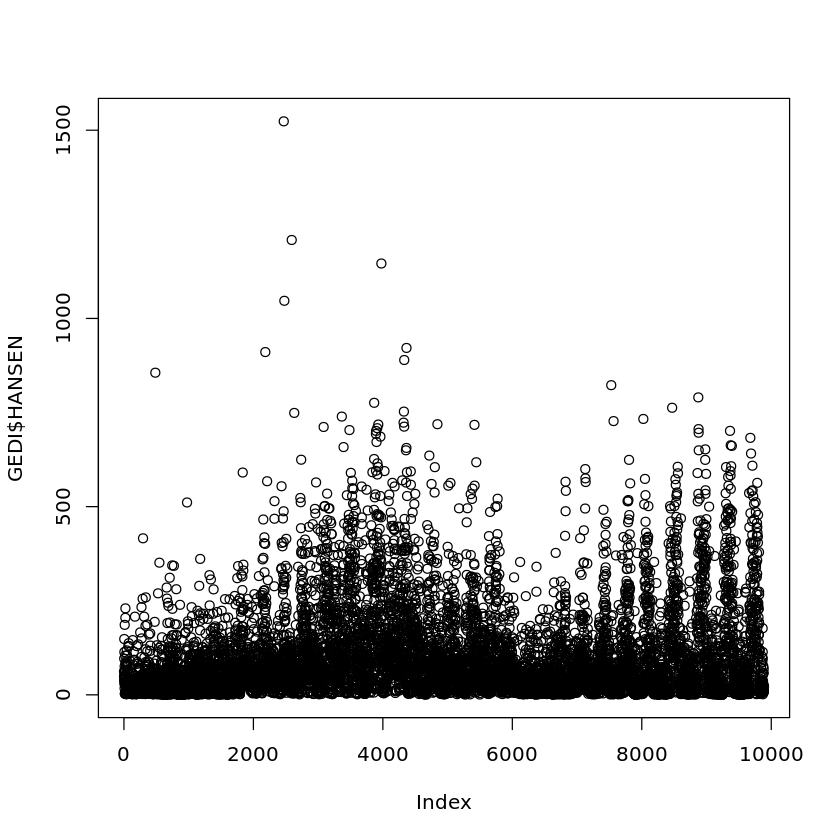

In [28]:
# HANSEN.plot = exactextractr::exact_extract(HANSEN, st_buffer(GEDI,25), 'mean')
# GEDI$HANSEN <- HANSEN.plot
HANSEN.plot = terra::extract(HANSEN, GEDI)
GEDI$HANSEN <- HANSEN.plot$WA_Hansen_6933
plot(GEDI$AGBD_1,GEDI$HANSEN)
summary(lm(sqrt(GEDI$AGBD_1) ~ GEDI$HANSEN))

ggplot(data=GEDI, aes(x=AGBD_1, y=HANSEN) ) +
  geom_bin2d(bins = 100) +
  scale_fill_gradient(limits = c(0, 20)) + xlab("Square root NFI AGBD [Mg/ha]") + ylab("HANSEN AGBD [Mg/ha]") + ggtitle("sqrt(AGB) vs. HANSEN") + xlim(0,250) + 
  theme_bw() + theme(text = element_text(size = 24),plot.title = element_text(color="red", size=12, face="bold.italic"),panel.grid.major = element_blank(), panel.grid.minor = element_blank(),panel.background = element_blank(), axis.line = element_line(colour = "black"))

In [113]:
coords <- as.data.frame(st_coordinates(GEDI))
GEDI$X <- coords$X
GEDI$Y <- coords$Y
write.csv(GEDI %>% st_drop_geometry(),"/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/GMB_Test/GEDIL4A_and_COVARIATES.csv",row.names=FALSE) #Save the data

In [114]:
DATA = read.csv("/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/GMB_Test/GEDIL4A_and_COVARIATES.csv")
DATA$gedi.agbd <- (DATA$AGBD_1)
DATA$HANSEN.tc <- (DATA$HANSEN)

dt = sort(sample(nrow(DATA), nrow(DATA)*.5))
DATA <- DATA[dt,]
write.csv(DATA,"/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/GMB_Test/DATA.csv",row.names=FALSE) #Save the data
DATA_TEST <- DATA[-dt,]
write.csv(DATA_TEST,"/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/GMB_Test/DATA_TEST.csv",row.names=FALSE) #Save the data

Time used:
    Pre = 0.725, Running = 1.85, Post = 0.185, Total = 2.76 
Fixed effects:
            mean     sd 0.025quant 0.5quant 0.975quant   mode kld
intercept -1.098 31.591    -63.016   -1.098     60.820 -1.098   0
HANSEN     7.968 26.048    -43.086    7.968     59.022  7.968   0

Random effects:
  Name	  Model
    alpha.spat SPDE2 model
   beta.spat SPDE2 model

Model hyperparameters:
                                           mean       sd 0.025quant 0.5quant
Precision for the Gaussian observations    0.42    0.003      0.414     0.42
Range for alpha.spat                    5011.18  767.280   3643.367  4962.67
Stdev for alpha.spat                     549.46   65.227    431.967   545.73
Range for beta.spat                     7797.80 1446.852   5414.550  7641.92
Stdev for beta.spat                       26.58    4.838     18.580    26.06
                                        0.975quant    mode
Precision for the Gaussian observations   4.27e-01    0.42
Range for alpha.spat       

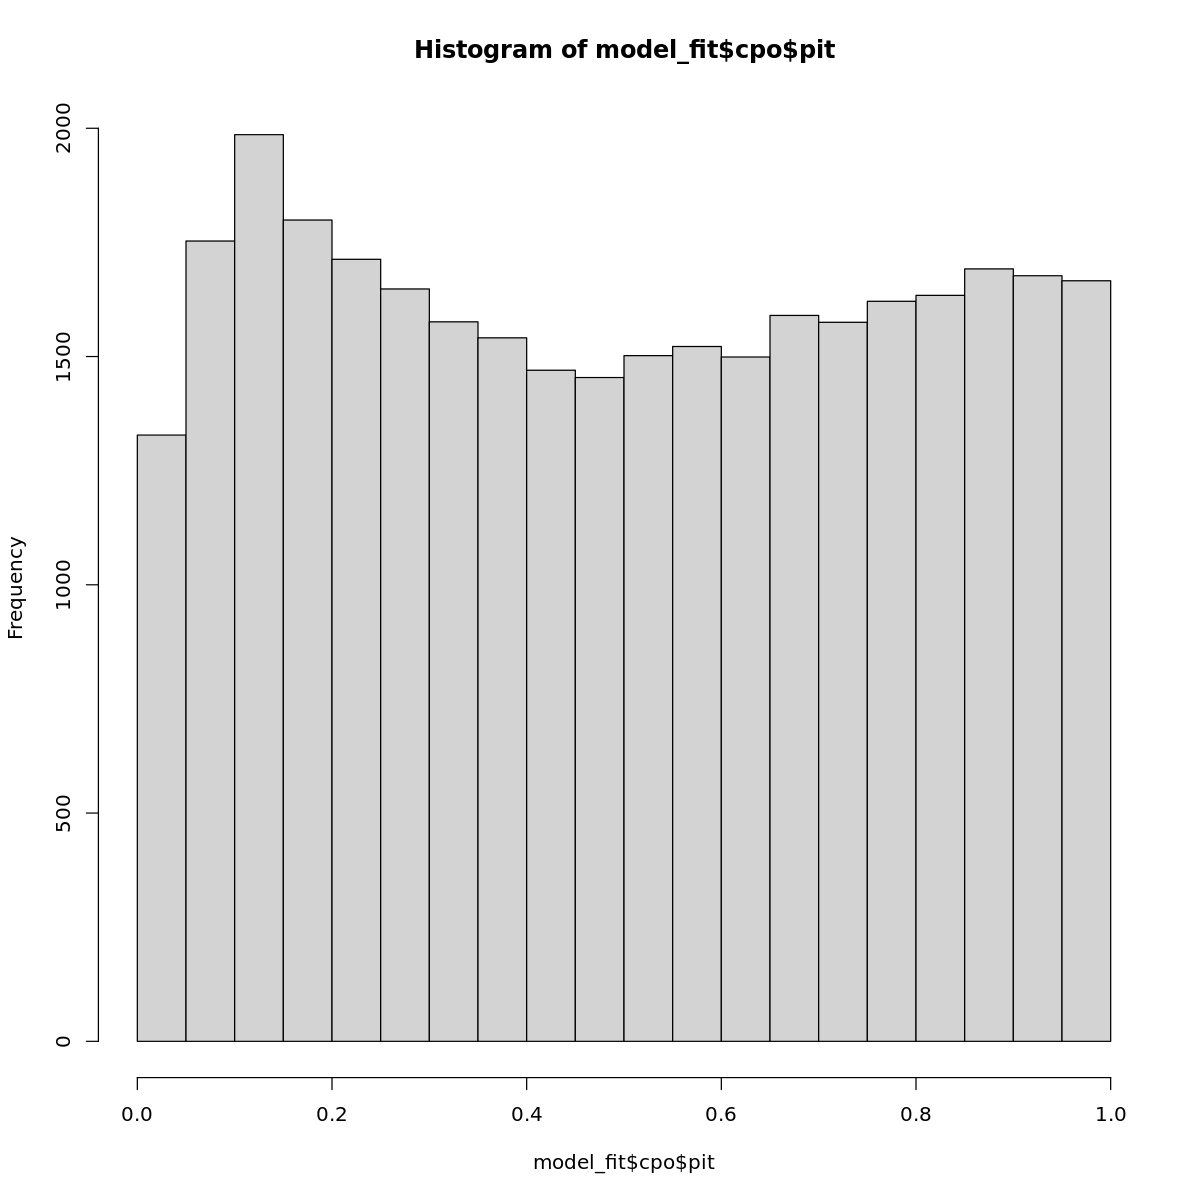

In [115]:
DATA <- read.csv("/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/GMB_Test/DATA.csv")
DATA$gedi.agbd <- (DATA$gedi.agbd)^(1/3)

loc.plot <- data.matrix(as.data.frame(cbind(DATA$X,DATA$Y)))
gedi.agbd <- DATA$gedi.agbd
HANSEN.tc <- DATA$HANSEN.tc

max.edge = 500
Sudan.buffer = st_buffer(Sudan, dist = max.edge*5) # We also make a 5 km buffer around Sudan to prevent boundary effects.
mesh = inla.mesh.2d(boundary = list(as(Sudan, "Spatial"), as(Sudan.buffer, "Spatial")), max.edge = c(max.edge, 3*max.edge), cutoff = 2*max.edge/3, offset = c(max.edge, 5*max.edge)) 
k = mesh$n ### This is the resulting number of vertices
loc.plot <- data.matrix(loc.plot) #In case loc.plot is a df rather than matrix, use "loc.plot <- data.matrix(loc.plot)"
n.plot = nrow(loc.plot)
A.plot = inla.spde.make.A(mesh = mesh, loc = loc.plot) # make a new projector matrix with the new mesh and the same plot locations. 
spde.alpha = inla.spde2.pcmatern(mesh, 
                                 prior.range = c(30000, 0.01), # This says the probability that the range is LESS than 30 km is 0.01
                                 prior.sigma = c(60, 0.01)) # This says the probability that the sd is GREATER than 60 Mg/ha is 0.01

# Priors for the varying coefficient beta_tilde
spde.beta = inla.spde2.pcmatern(mesh, 
                                prior.range = c(30000, 0.01), # Same interpretations here
                                prior.sigma = c(1, 0.5)) # This says the probability that the sd is GREATER than 1 is 0.5

### Construct our formula #####
formula = agbd ~
  -1 + # removes the automatic intercept so you can include your named intercept
  intercept + 
  HANSEN +
  f(alpha.spat, model = spde.alpha) + 
  f(beta.spat, model = spde.beta) 
## Arrange our data so we can supply it to INLA to input in the formula above #####
stack = inla.stack(data = list(agbd = gedi.agbd),
                   A = list(1, 
                            1, 
                            A.plot, 
                            Diagonal(x = HANSEN.tc)%*%A.plot),# 
                   effects = list(
                     intercept = rep(1, n.plot),
                     HANSEN = HANSEN.tc,
                     alpha.spat = 1:k, 
                     beta.spat = 1:k)
                  )

# Below, notice the arguments in 'control.mode = ' We tell INLA our starting parameters in "theta=", but tell it to restart the optimization from 
# there (restart = T), using the outputs of model_fit generated previously. It will still take a while, but less than it would have if we started from scratch

model_fit = inla(formula = formula, # Provide the formula
                 family = 'gaussian', # We assume our data follows a Gaussian generalized linear model (GLM)
                 data = inla.stack.data(stack), # These line and the one below are simply how we feed INLA the stack.
                 control.predictor = list(A = inla.stack.A(stack)),
                 control.compute = list(config = T, dic = T, waic = T, cpo = T),
                 control.inla = list(int.strategy = "eb"), # EB just fixes the hyperparameters at their maximum posterior (like maximum likelihood, but accounting for priors) values. The other methods manually integrate across the range of possible values.
                 verbose = TRUE)
summary(model_fit)
save(model_fit, file = "/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/GMB_Test/INLA_model_fit.RData")
hist(model_fit$cpo$pit, breaks = 20) 

Warning message in .local(x, y, ...):
“Polygons transformed to raster CRS (EPSG:6933)”


ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'x' in selecting a method for function 'sort': error in evaluating the argument 'x' in selecting a method for function 'unique': incorrect number of dimensions


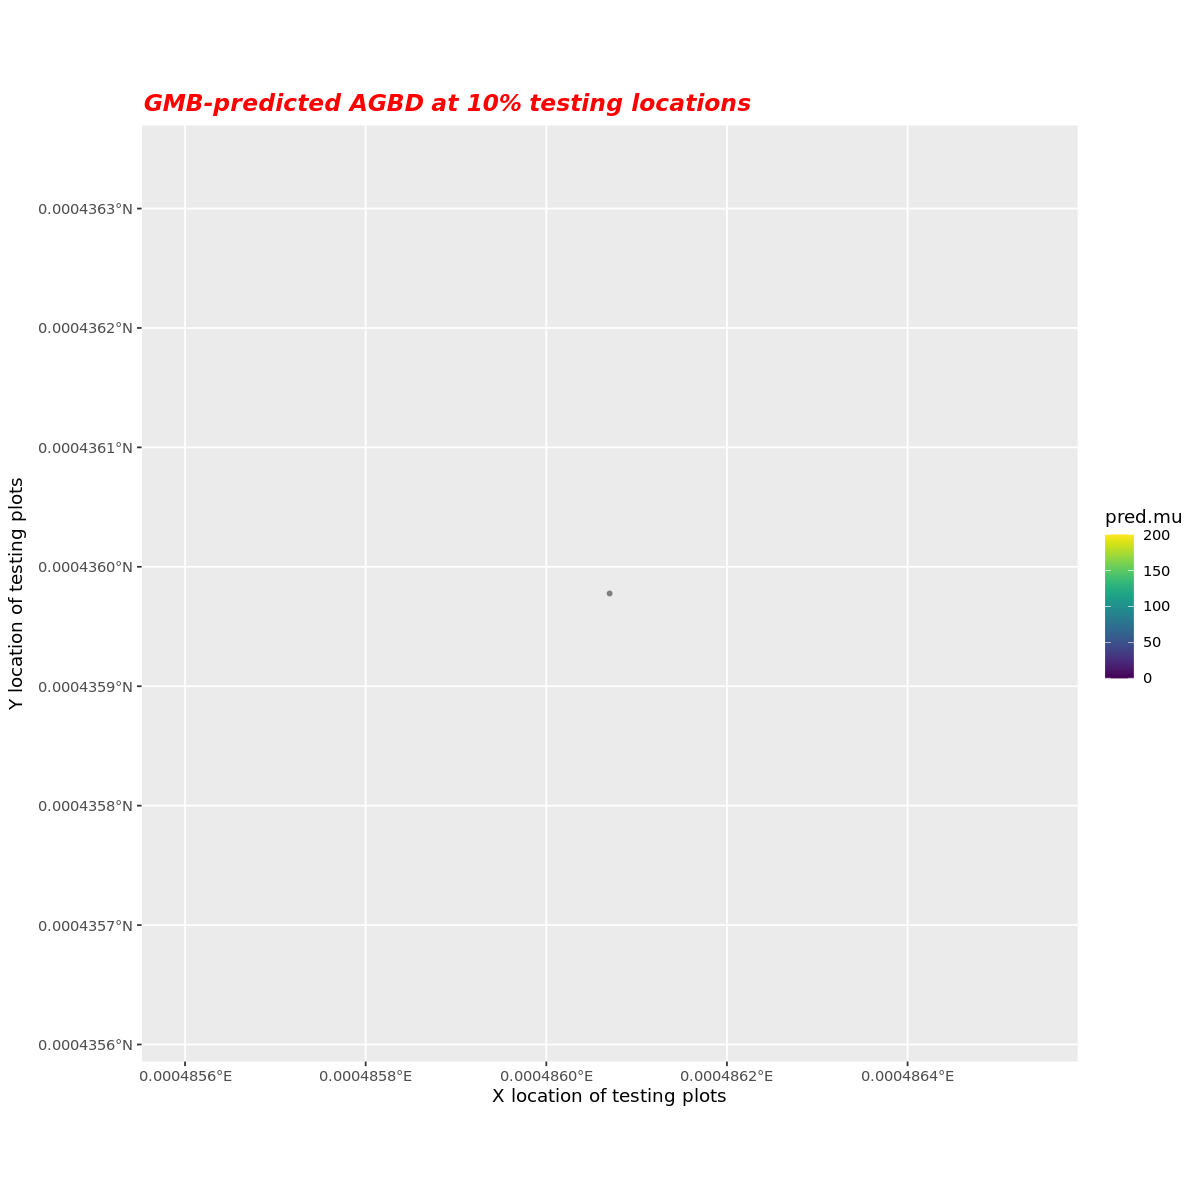

In [116]:
load("/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/GMB_Test/INLA_model_fit.RData")
grid_to_predict = st_make_grid(Sudan, cellsize = c(100,100), what = "centers") %>% st_as_sf()
HANSEN.pred = exactextractr::exact_extract(HANSEN, st_buffer(grid_to_predict,25), 'mean')
grid = as.data.frame(grid_to_predict %>% st_coordinates())

loc.plot_T <- data.matrix(as.data.frame(cbind(grid$X,grid$Y)))

samples = inla.posterior.sample(n = 20, result = model_fit) # Draw posterior samples from our model fit 
A.pred = inla.spde.make.A(mesh = mesh, loc = loc.plot_T) # Make a new projector matrix with the same mesh, but new plot locations 

# Our model function
pred_fun = function(...){
  drop(intercept + 
    HANSEN.pred*HANSEN +
    A.pred%*%alpha.spat[1:k] +   
    Diagonal(x = HANSEN.pred)%*%A.pred%*%beta.spat[1:k]) + 
    rnorm(nrow(A.pred), sd = sqrt(1/theta[1])) 
}

# Generate prediction samples, i.e. ask INLA to use the prediction function and samples to make predictions at our testing plot locations. 
pred.samples = (inla.posterior.sample.eval(fun = pred_fun,samples = samples)) #

# Model mean AGBD expectations and SD's at the grid locations
pred.mu = Matrix::rowMeans(pred.samples^3)
pred.sd = apply(pred.samples^3, 1, sd)
options(repr.plot.width=10, repr.plot.height=10)

####################### And here are some maps to see what the predictions look like at the plot locations ##########
ggplot() + coord_sf(crs = 6933) + 
           geom_point(aes(x = loc.plot_T[,1], y = loc.plot_T[,2], col = pred.mu),size=1) +  # make a map to see plot locations and the AGBD values at each location
           scale_color_viridis(limits = c(0, 200)) + xlab("X location of testing plots") + ylab("Y location of testing plots") + ggtitle("GMB-predicted AGBD at 10% testing locations") + theme(plot.title = element_text(color="red", size=14, face="bold.italic"))
           # geom_sf(data = Deforestation,col="red",fill=NA,lwd=1)# add our fake deforestation sites

xyz_data <- data.frame(x = loc.plot_T[,1], y = loc.plot_T[,2], z = pred.mu)
PREDICTIONS <- rasterFromXYZ(xyz_data)
crs(PREDICTIONS) <- CRS("+init=epsg:6933")
writeRaster(PREDICTIONS, "/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/GMB_Test/fid_122_mean.tif", format = "GTiff", overwrite=TRUE)

xyz_data <- data.frame(x = loc.plot_T[,1], y = loc.plot_T[,2], z = pred.sd)
PREDICTIONS <- rasterFromXYZ(xyz_data)
crs(PREDICTIONS) <- CRS("+init=epsg:6933")
writeRaster(PREDICTIONS, "/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/GMB_Test/fid_122_SD.tif", format = "GTiff", overwrite=TRUE)

Time used:
    Pre = 1.25, Running = 297, Post = 16, Total = 314 
Fixed effects:
           mean     sd 0.025quant 0.5quant 0.975quant  mode kld
intercept 1.104 13.783     -25.91    1.104     28.117 1.104   0
cci       0.037  2.458      -4.78    0.037      4.854 0.037   0

Random effects:
  Name	  Model
    alpha.spat SPDE2 model
   beta.spat SPDE2 model

Model hyperparameters:
                                            mean       sd 0.025quant 0.5quant
Precision for the Gaussian observations 7.00e-01 1.70e-02   6.67e-01 7.00e-01
Range for alpha.spat                    1.67e+05 1.36e+05   3.64e+04 1.29e+05
Stdev for alpha.spat                    4.09e+00 3.35e+00   8.49e-01 3.15e+00
Range for beta.spat                     3.91e+05 9.34e+05   5.79e+03 1.41e+05
Stdev for beta.spat                     6.80e-01 1.62e+00   1.00e-02 2.47e-01
                                        0.975quant     mode
Precision for the Gaussian observations   7.34e-01 7.01e-01
Range for alpha.spat           

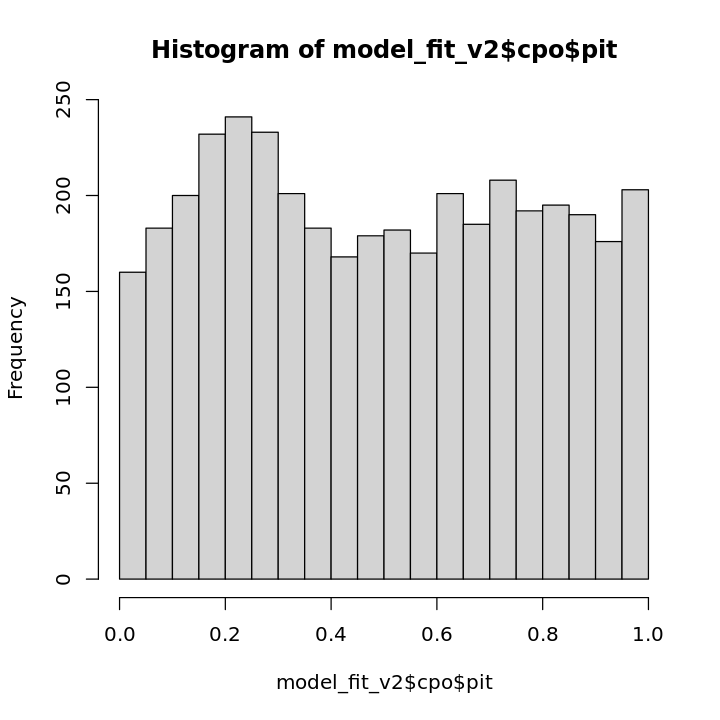

In [33]:
################## IMPROVING OUR MODEL ############

# Before we move ahead, let's try improve our model by making a finer mesh. We choose to rougly 2/3rds our max.edge (10 km) and see if our model improves. 

max.edge = 100
Sudan.buffer = st_buffer(Sudan, dist = max.edge*5) # We also make a 5 km buffer around Sudan to prevent boundary effects.
mesh = inla.mesh.2d(boundary = list(as(Sudan, "Spatial"), as(Sudan.buffer, "Spatial")), max.edge = c(max.edge, 3*max.edge), cutoff = 2*max.edge/3, offset = c(max.edge, 5*max.edge)) 
k = mesh$n ### This is the resulting number of vertices
loc.plot <- data.matrix(loc.plot) #In case loc.plot is a df rather than matrix, use "loc.plot <- data.matrix(loc.plot)"
n.plot = nrow(loc.plot)
A.plot = inla.spde.make.A(mesh = mesh, loc = loc.plot) # make a new projector matrix with the new mesh and the same plot locations. 
spde.alpha = inla.spde2.pcmatern(mesh, 
                                 prior.range = c(30000, 0.01), # This says the probability that the range is LESS than 30 km is 0.01
                                 prior.sigma = c(60, 0.01)) # This says the probability that the sd is GREATER than 60 Mg/ha is 0.01

# Priors for the varying coefficient beta_tilde
spde.beta = inla.spde2.pcmatern(mesh, 
                                prior.range = c(30000, 0.01), # Same interpretations here
                                prior.sigma = c(1, 0.5)) # This says the probability that the sd is GREATER than 1 is 0.5

### Construct our formula #####
formula = agbd ~
  -1 + # removes the automatic intercept so you can include your named intercept
  intercept + 
  HANSEN +
  f(alpha.spat, model = spde.alpha) + 
  f(beta.spat, model = spde.beta) 
## Arrange our data so we can supply it to INLA to input in the formula above #####
stack = inla.stack(data = list(agbd = gedi.agbd),
                   A = list(1, 
                            1, 
                            A.plot, 
                            Diagonal(x = HANSEN.tc)%*%A.plot),# 
                   effects = list(
                     intercept = rep(1, n.plot),
                     HANSEN = HANSEN.tc,
                     alpha.spat = 1:k, 
                     beta.spat = 1:k)
                  )

# Below, notice the arguments in 'control.mode = ' We tell INLA our starting parameters in "theta=", but tell it to restart the optimization from 
# there (restart = T), using the outputs of model_fit generated previously. It will still take a while, but less than it would have if we started from scratch

model_fit_v2 = inla(formula = formula, # Provide the formula
                 family = 'gaussian', # We assume our data follows a Gaussian generalized linear model (GLM)
                 data = inla.stack.data(stack), # These line and the one below are simply how we feed INLA the stack.
                 control.predictor = list(A = inla.stack.A(stack)),
                 control.compute = list(config = T, dic = T, waic = T, cpo = T),
                 control.inla = list(int.strategy = "eb"), # EB just fixes the hyperparameters at their maximum posterior (like maximum likelihood, but accounting for priors) values. The other methods manually integrate across the range of possible values.
                 control.mode = list(theta = model_fit$mode$theta, restart = T), #Ask INLA to restart the model using the previous iteration
                 verbose = TRUE)
summary(model_fit_v2)
save(model_fit_v2, file = "/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/GMB_Test/INLA_model_v2.RData")
hist(model_fit_v2$cpo$pit, breaks = 20) 

# options(repr.plot.width=4, repr.plot.height=4)
# load("/projects/my-public-bucket/Data/NASA_CMS_2023/Sudan/RData_saves/INLA_model_fit_v2.RData")
# summary(model_fit_v2)
# hist(model_fit_v2$cpo$pit, breaks = 20) 

# We don't see a massive improvement in either the PIT distributions, the DIC or WAIC values. 
# We can conclude that using a max.edge of 10 km is sufficient and there is no further need to refine our mesh. 

  |======================================================================| 100%


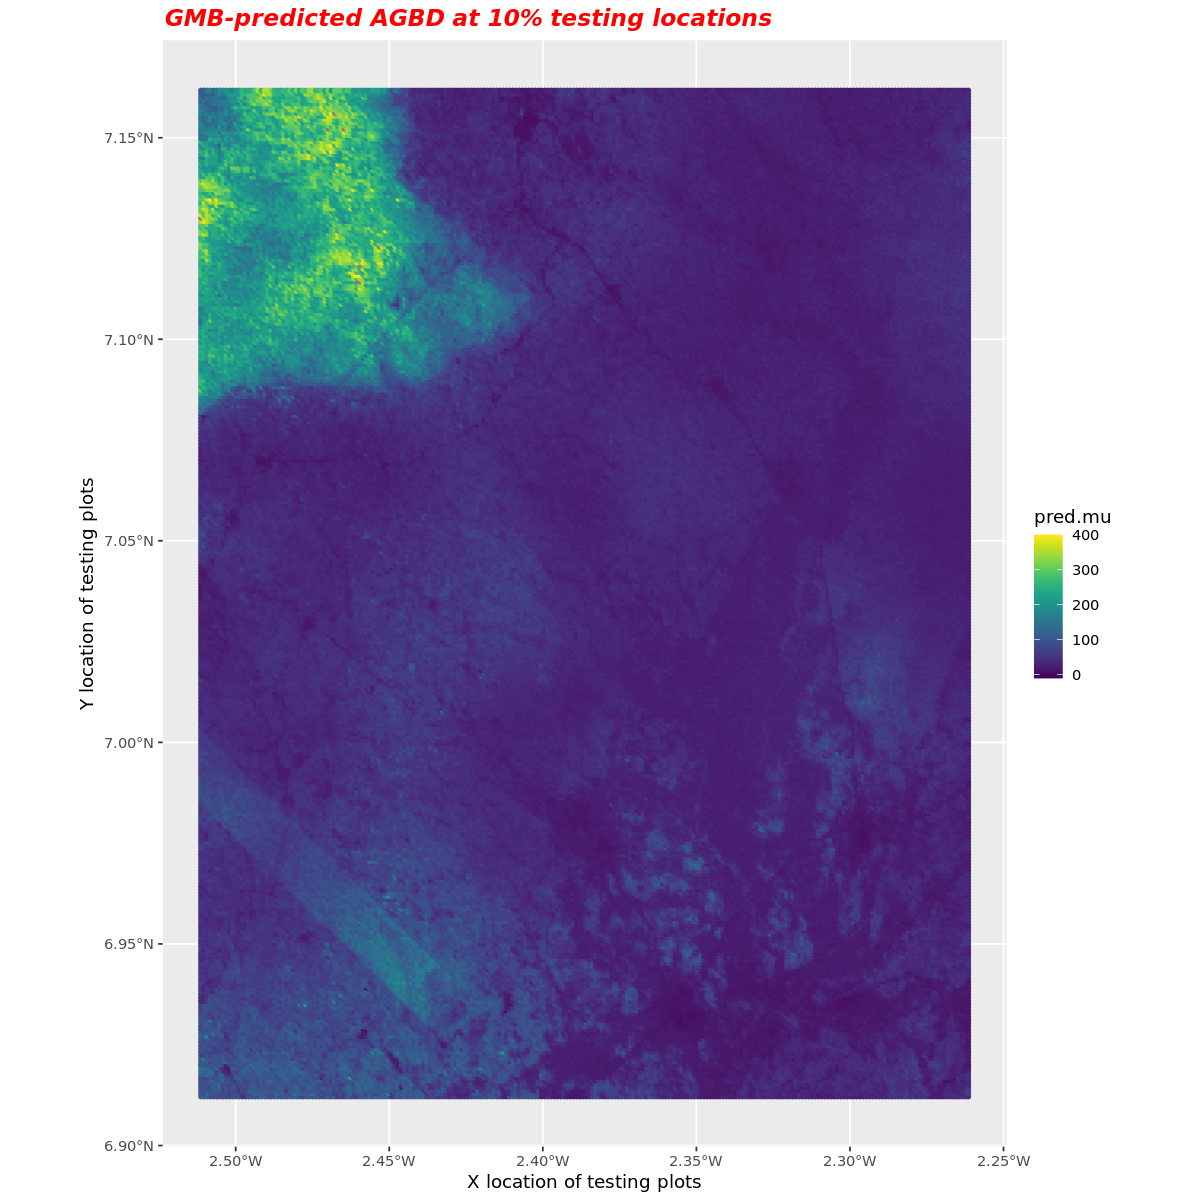

In [36]:
load("/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/GMB_Test/INLA_model_v2.RData")
grid_to_predict = st_make_grid(Sudan, cellsize = c(100,100), what = "centers") %>% st_as_sf()
HANSEN.pred = exactextractr::exact_extract(HANSEN, st_buffer(grid_to_predict,25), 'mean')
grid = as.data.frame(grid_to_predict %>% st_coordinates())

loc.plot_T <- data.matrix(as.data.frame(cbind(grid$X,grid$Y)))

samples = inla.posterior.sample(n = 200, result = model_fit_v2) # Draw posterior samples from our model fit 
A.pred = inla.spde.make.A(mesh = mesh, loc = loc.plot_T) # Make a new projector matrix with the same mesh, but new plot locations 

# Our model function
pred_fun = function(...){
  drop(intercept + 
    HANSEN.pred*HANSEN +
    A.pred%*%alpha.spat[1:k] +   
    Diagonal(x = HANSEN.pred)%*%A.pred%*%beta.spat[1:k]) + 
    rnorm(nrow(A.pred), sd = sqrt(1/theta[1])) 
}

# Generate prediction samples, i.e. ask INLA to use the prediction function and samples to make predictions at our testing plot locations. 
pred.samples = (inla.posterior.sample.eval(fun = pred_fun,samples = samples)) #

# Model mean AGBD expectations and SD's at the grid locations
pred.mu = Matrix::rowMeans(pred.samples^3)
pred.sd = apply(pred.samples^3, 1, sd)
options(repr.plot.width=10, repr.plot.height=10)

####################### And here are some maps to see what the predictions look like at the plot locations ##########
ggplot() + coord_sf(crs = 6933) + 
           geom_point(aes(x = loc.plot_T[,1], y = loc.plot_T[,2], col = pred.mu),size=1) +  # make a map to see plot locations and the AGBD values at each location
           scale_color_viridis(limits = c(-10, 400)) + xlab("X location of testing plots") + ylab("Y location of testing plots") + ggtitle("GMB-predicted AGBD at 10% testing locations") + theme(plot.title = element_text(color="red", size=14, face="bold.italic"))
           # geom_sf(data = Deforestation,col="red",fill=NA,lwd=1)# add our fake deforestation sites

Warning message:
“Removed 181 rows containing missing values or values outside the scale range
(`geom_point()`).”


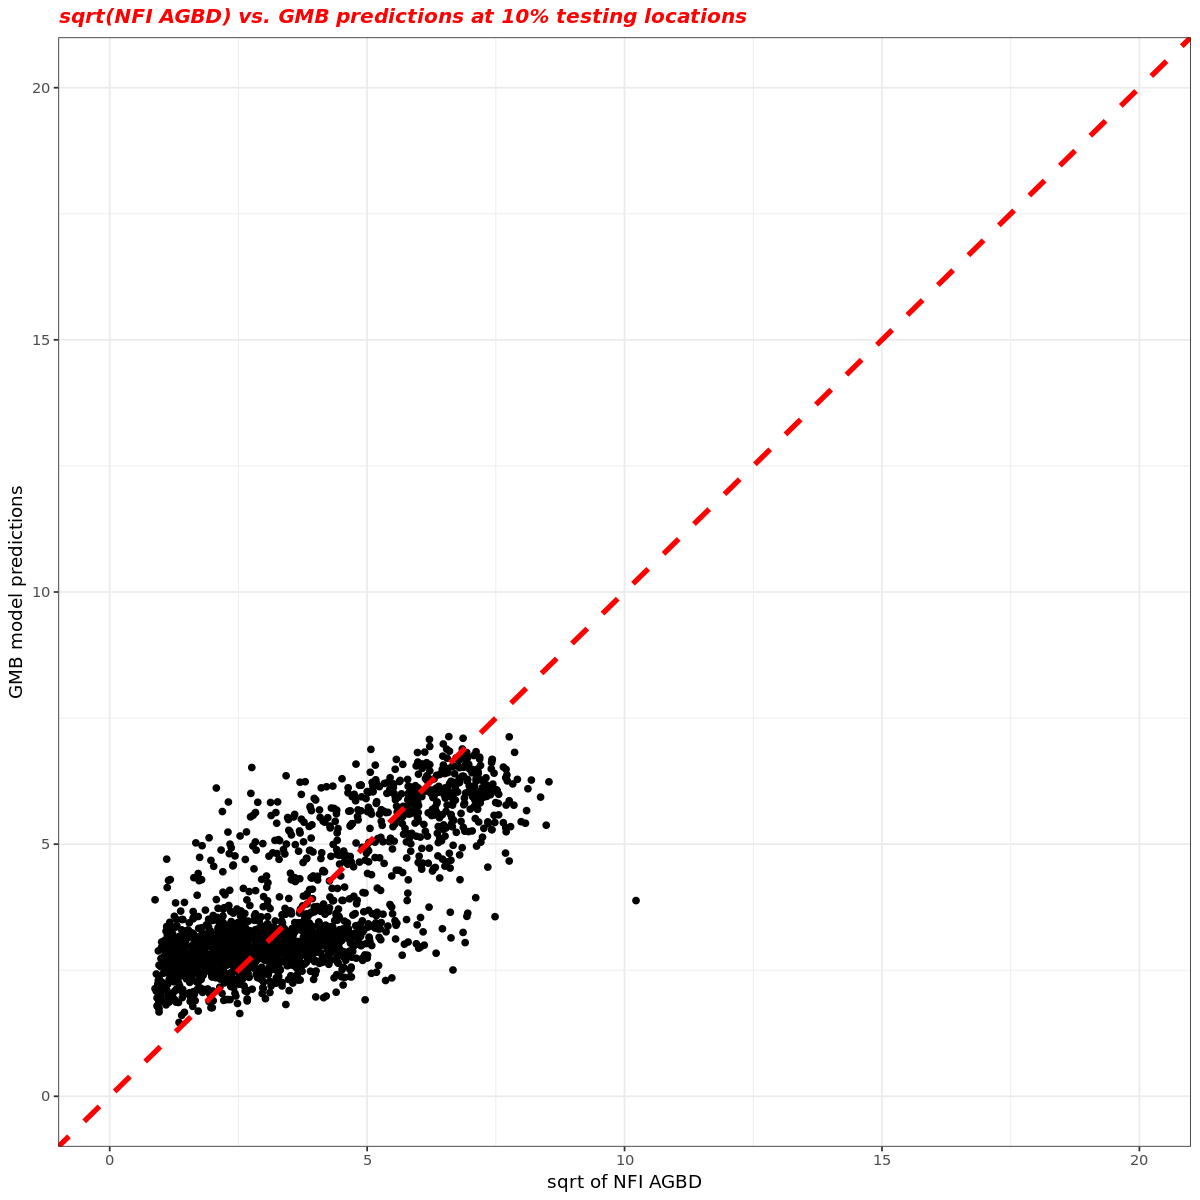

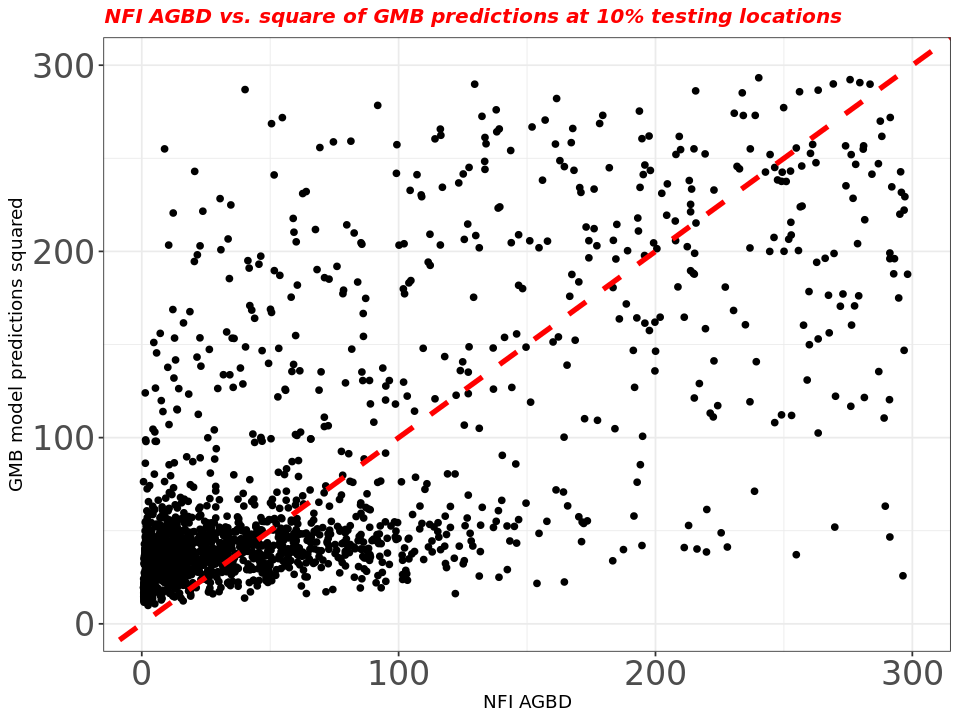

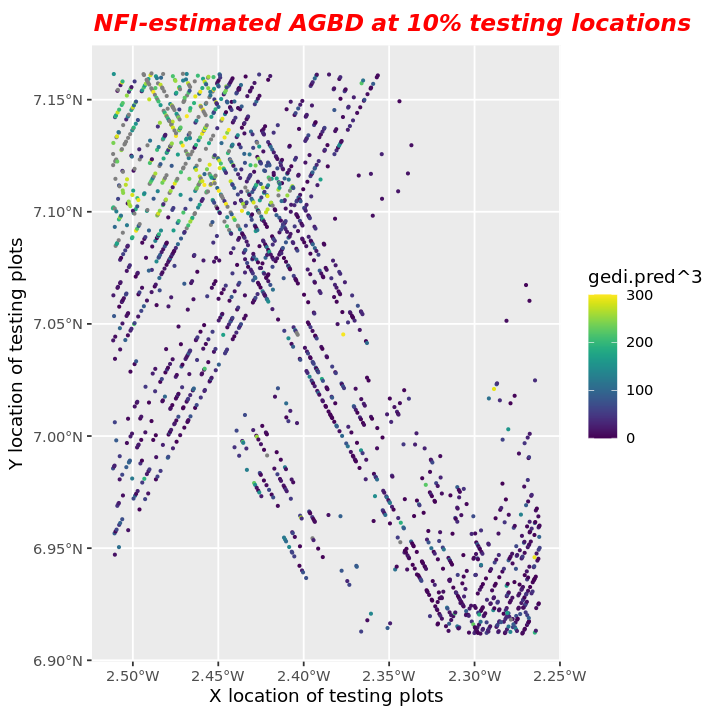

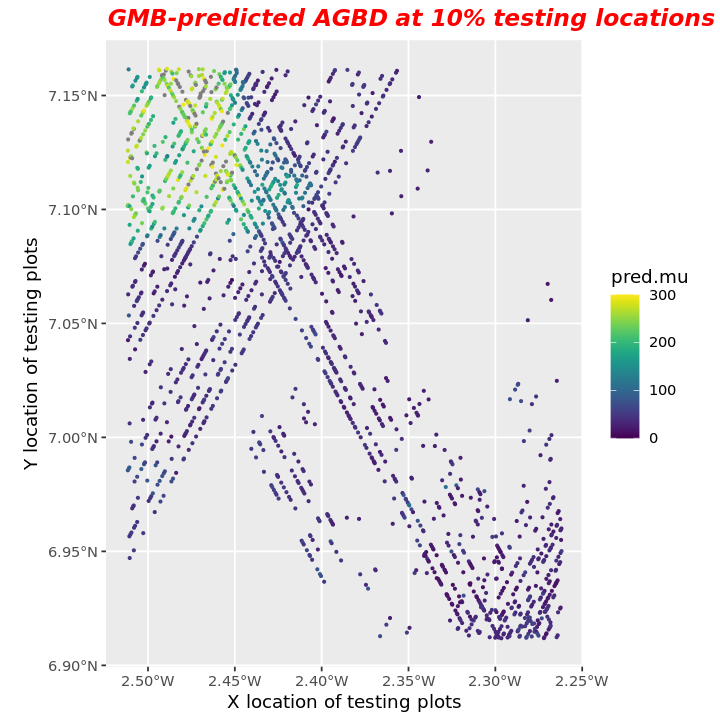

In [26]:
DATA_TEST <- read.csv("/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/GMB_Test/DATA_TEST.csv")
DATA_TEST$gedi.agbd <- (DATA_TEST$gedi.agbd)^(1/3)

loc.plot_T <- data.matrix(as.data.frame(cbind(DATA_TEST$X,DATA_TEST$Y)))
gedi.pred <- (DATA_TEST$gedi.agbd)
HANSEN.pred <- DATA_TEST$HANSEN.tc

samples = inla.posterior.sample(n = 250, result = model_fit) # Draw posterior samples from our model fit 
A.pred = inla.spde.make.A(mesh = mesh, loc = loc.plot_T) # Make a new projector matrix with the same mesh, but new plot locations 

# Our model function
pred_fun = function(...){
  drop(intercept + 
    HANSEN.pred*HANSEN +
    A.pred%*%alpha.spat[1:k] +   
    Diagonal(x = HANSEN.pred)%*%A.pred%*%beta.spat[1:k]) + 
    rnorm(nrow(A.pred), sd = sqrt(1/theta[1])) 
}

# Generate prediction samples, i.e. ask INLA to use the prediction function and samples to make predictions at our testing plot locations. 
pred.samples = (inla.posterior.sample.eval(fun = pred_fun,samples = samples)) #

# Model mean AGBD expectations and SD's at the grid locations
pred.mu = Matrix::rowMeans(pred.samples)
pred.sd = apply(pred.samples, 1, sd)

OUTPUT <- do.call(rbind, Map(data.frame, PRED=pred.mu, NFI=gedi.pred, PRED.SD=pred.sd, RES=gedi.pred-pred.mu))
ggplot(data = OUTPUT, aes(x = NFI,y = PRED))+ geom_point() + geom_abline(size=0.5,linetype=2,col="red",lwd=1.5) + theme_bw() + xlim(0,20) + ylim(0,20) + xlab("sqrt of NFI AGBD") + ylab("GMB model predictions") + ggtitle("sqrt(NFI AGBD) vs. GMB predictions at 10% testing locations") + theme(plot.title = element_text(color="red", size=12, face="bold.italic"))

################## COMPUTE A HEURISTIC FOR ACCURACY, LIKE AN R2 VALUE #############
 # Computing a value like an R^2 for our testing locations will give us an idea of prediction error at unobserved locations

# Let's also square the model expectations because we applied a sqrt transformation at the start
pred.mu = Matrix::rowMeans(pred.samples^3)
pred.sd = apply(pred.samples^3, 1, sd)

OUTPUT <- do.call(rbind, Map(data.frame, PRED=pred.mu, NFI=gedi.pred^3, PRED.SD=pred.sd, RES=gedi.pred^3-pred.mu))
options(repr.plot.width=8, repr.plot.height=6)
ggplot(data = OUTPUT, aes(x = NFI,y = PRED))+ geom_point()  + geom_abline(size=0.5,linetype=2,col="red",lwd=1.5) + theme_bw() + xlim(0,300) + ylim(0,300) + xlab("NFI AGBD") + ylab("GMB model predictions squared") + ggtitle("NFI AGBD vs. square of GMB predictions at 10% testing locations") + theme(plot.title = element_text(color="red", size=12, face="bold.italic"),axis.text=element_text(size=20))
        
####################### And here are some maps to see what the predictions look like at the plot locations ##########
options(repr.plot.width=6, repr.plot.height=6)
ggplot() + coord_sf(crs = 6933) + 
           geom_point(aes(x = loc.plot_T[,1], y = loc.plot_T[,2], col = gedi.pred^3),size=0.5) +  # make a map to see plot locations and the AGBD values at each location
           scale_color_viridis(limits = c(0, 300)) + xlab("X location of testing plots") + ylab("Y location of testing plots") + ggtitle("NFI-estimated AGBD at 10% testing locations") + theme(plot.title = element_text(color="red", size=14, face="bold.italic"))
           # geom_sf(data = Deforestation,col="red",fill=NA,lwd=1)# add our fake deforestation sites

ggplot() + coord_sf(crs = 6933) + 
           geom_point(aes(x = loc.plot_T[,1], y = loc.plot_T[,2], col = pred.mu),size=0.5) +  # make a map to see plot locations and the AGBD values at each location
           scale_color_viridis(limits = c(0, 300)) + xlab("X location of testing plots") + ylab("Y location of testing plots") + ggtitle("GMB-predicted AGBD at 10% testing locations") + theme(plot.title = element_text(color="red", size=14, face="bold.italic"))
           # geom_sf(data = Deforestation,col="red",fill=NA,lwd=1)# add our fake deforestation sites

[1]   3882 115291

[1] 3882

Time used:
    Pre = 0.817, Running = 238, Post = 8.15, Total = 247 
Fixed effects:
            mean     sd 0.025quant 0.5quant 0.975quant   mode kld
intercept 38.599 19.816      -0.24   38.599     77.437 38.599   0

Random effects:
  Name	  Model
    alpha.spat SPDE2 model

Model hyperparameters:
                                           mean      sd 0.025quant 0.5quant
Precision for the Gaussian observations    0.00    0.00       0.00     0.00
Range for alpha.spat                    7793.02 1528.10    5311.00  7617.36
Stdev for alpha.spat                      75.82   10.66      57.57    74.89
                                        0.975quant    mode
Precision for the Gaussian observations       0.00    0.00
Range for alpha.spat                      11301.41 7230.75
Stdev for alpha.spat                         99.46   72.73

Deviance Information Criterion (DIC) ...............: 44599.98
Deviance Information Criterion (DIC, saturated) ....: 1700.91
Effective number of parameters ....

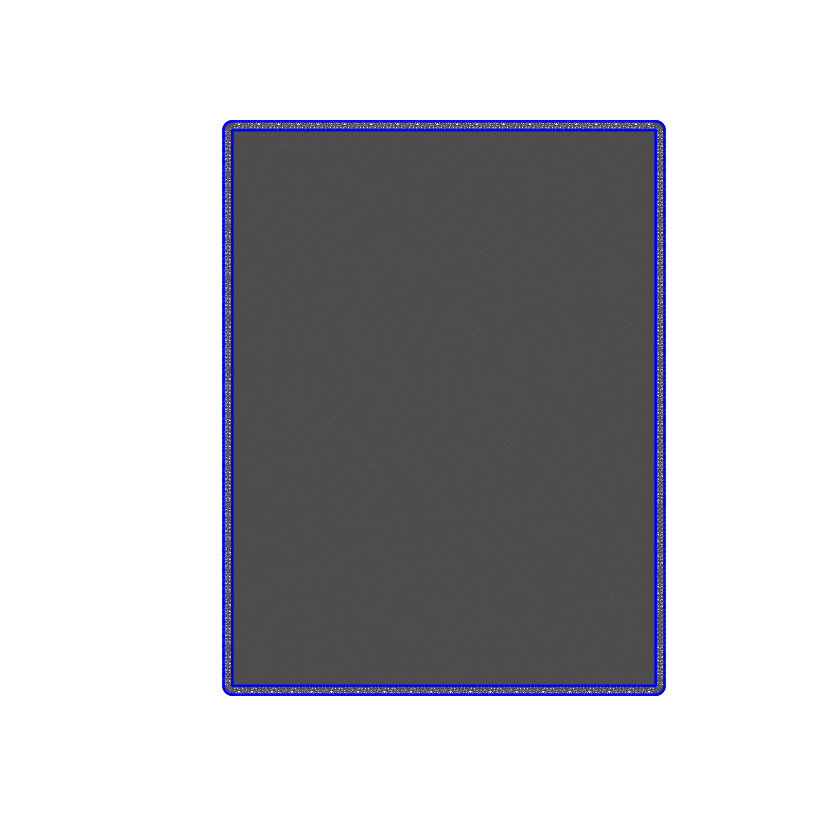

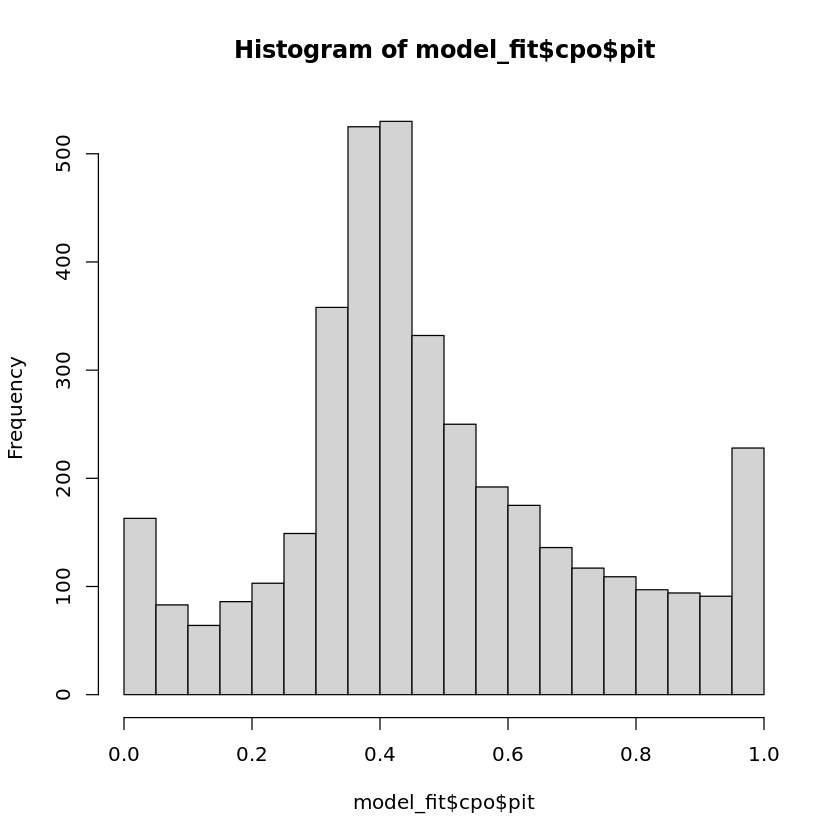

In [8]:
DATA <- read.csv("/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/GMB_Test/DATA.csv")
DATA$gedi.agbd <- (DATA$gedi.agbd)

loc.plot <- data.matrix(as.data.frame(cbind(DATA$X,DATA$Y)))
gedi.agbd <- (DATA$gedi.agbd)

max.edge = 100
Sudan.buffer = st_buffer(Sudan, dist = max.edge*5) # We also make a 5 km buffer around Sudan to prevent boundary effects.
mesh = inla.mesh.2d(boundary = list(as(Sudan, "Spatial"), as(Sudan.buffer, "Spatial")), max.edge = c(max.edge, 3*max.edge), cutoff = 2*max.edge/3, offset = c(max.edge, 5*max.edge)) 
k = mesh$n ### This is the resulting number of vertices
loc.plot <- data.matrix(loc.plot) #In case loc.plot is a df rather than matrix, use "loc.plot <- data.matrix(loc.plot)"
n.plot = nrow(loc.plot)
A.plot = inla.spde.make.A(mesh = mesh, loc = loc.plot) # make a new projector matrix with the new mesh and the same plot locations. 
spde.alpha = inla.spde2.pcmatern(mesh, 
                                 prior.range = c(30000, 0.01), # This says the probability that the range is LESS than 30 km is 0.01
                                 prior.sigma = c(60, 0.01)) # This says the probability that the sd is GREATER than 60 Mg/ha is 0.01

# Priors for the varying coefficient beta_tilde
spde.beta = inla.spde2.pcmatern(mesh, 
                                prior.range = c(30000, 0.01), # Same interpretations here
                                prior.sigma = c(1, 0.5)) # This says the probability that the sd is GREATER than 1 is 0.5
plot(mesh)
dim(A.plot)
length(gedi.agbd)

### Construct our formula #####
formula = agbd ~
  -1 + # removes the automatic intercept so you can include your named intercept
  intercept + 
  f(alpha.spat, model = spde.alpha)
## Arrange our data so we can supply it to INLA to input in the formula above #####
stack = inla.stack(data = list(agbd = gedi.agbd),
                   A = list(1, 
                            A.plot),
                   effects = list(
                     intercept = rep(1, n.plot),
                     alpha.spat = 1:k)
                  )

# Below, notice the arguments in 'control.mode = ' We tell INLA our starting parameters in "theta=", but tell it to restart the optimization from 
# there (restart = T), using the outputs of model_fit generated previously. It will still take a while, but less than it would have if we started from scratch

model_fit = inla(formula = formula, # Provide the formula
                 family = 'gaussian', # We assume our data follows a Gaussian generalized linear model (GLM)
                 data = inla.stack.data(stack), # These line and the one below are simply how we feed INLA the stack.
                 control.predictor = list(A = inla.stack.A(stack)),
                 control.compute = list(config = T, dic = T, waic = T, cpo = T),
                 control.inla = list(int.strategy = "eb"), # EB just fixes the hyperparameters at their maximum posterior (like maximum likelihood, but accounting for priors) values. The other methods manually integrate across the range of possible values.
                 verbose = TRUE)
summary(model_fit)
save(model_fit, file = "/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/GMB_Test/INLA_model_DIRECT.RData")
hist(model_fit$cpo$pit, breaks = 20) 

# options(repr.plot.width=4, repr.plot.height=4)
# load("/projects/ADE_biomass_harmonization/biomass_harmonization/NASA_CMS_2023/Sudan/INLA_model_fit.RData")
# summary(model_fit_v2)
# hist(model_fit_v2$cpo$pit, breaks = 20) 

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
Warning message:
“Removed 406 rows containing missing values or values outside the scale range
(`geom_point()`).”


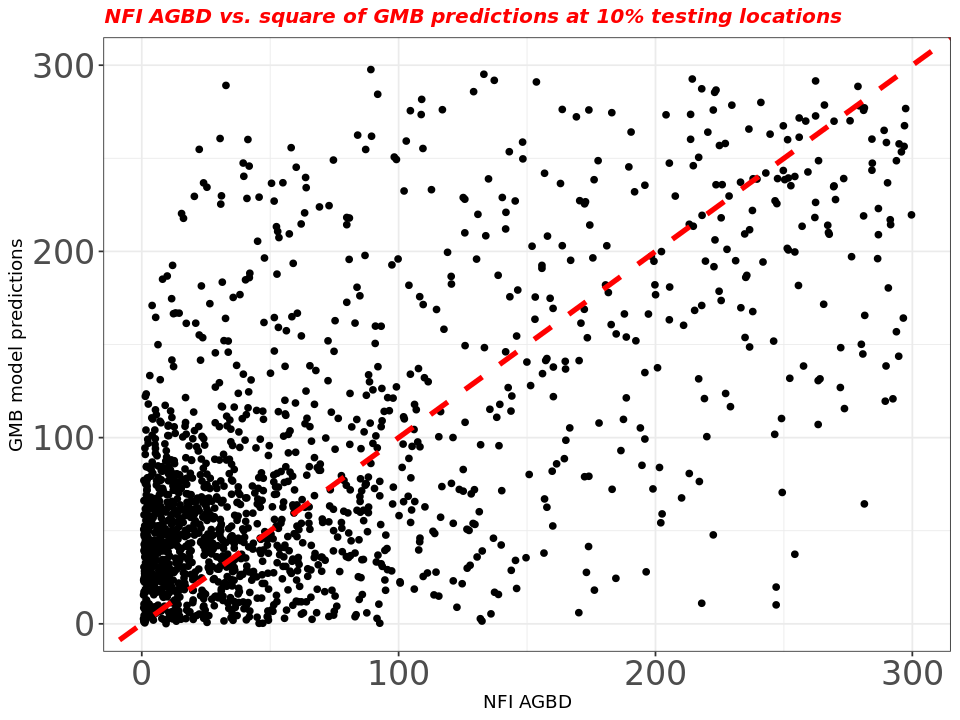

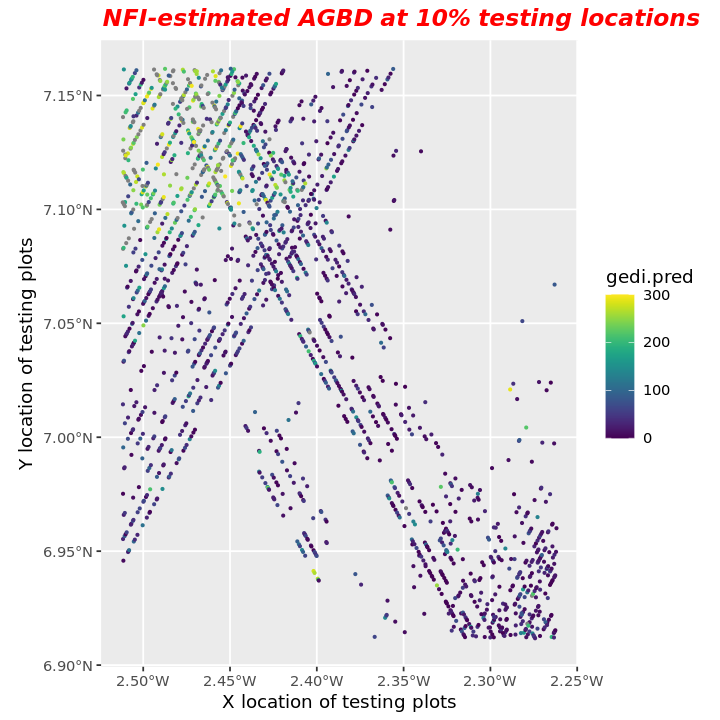

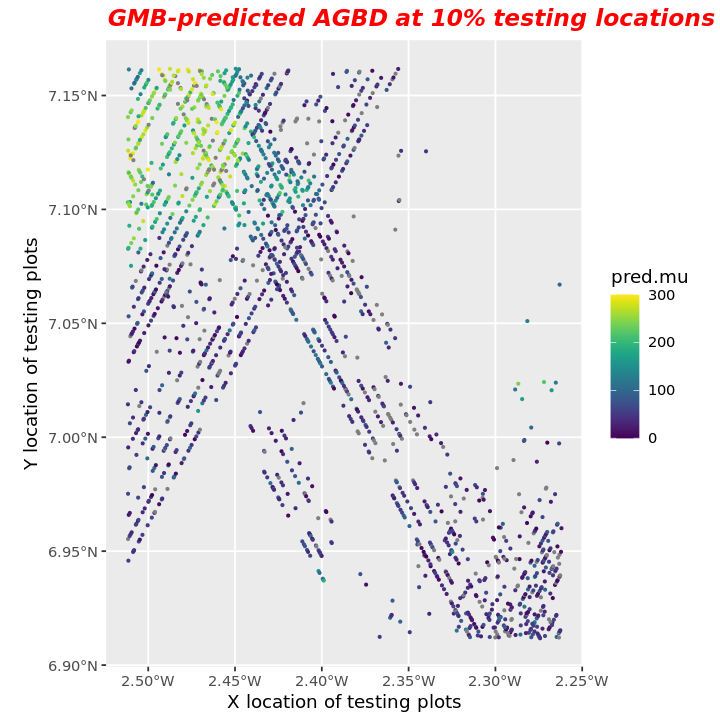

In [9]:
load("/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/GMB_Test/INLA_model_DIRECT.RData")
DATA_TEST <- read.csv("/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/GMB_Test/DATA_TEST.csv")

loc.plot_T <- data.matrix(as.data.frame(cbind(DATA_TEST$X,DATA_TEST$Y)))
gedi.pred <- (DATA_TEST$gedi.agbd)

samples = inla.posterior.sample(n = 5, result = model_fit) # Draw posterior samples from our model fit 
A.pred = inla.spde.make.A(mesh = mesh, loc = loc.plot_T) # Make a new projector matrix with the same mesh, but new plot locations 

# Our model function
pred_fun = function(...){
  drop(intercept + 
    A.pred%*%alpha.spat[1:k]) + 
    rnorm(nrow(A.pred), sd = sqrt(1/theta[1])) 
}

# Generate prediction samples, i.e. ask INLA to use the prediction function and samples to make predictions at our testing plot locations. 
pred.samples = (inla.posterior.sample.eval(fun = pred_fun,samples = samples)) #

# Model mean AGBD expectations and SD's at the grid locations
pred.mu = Matrix::rowMeans(pred.samples)
pred.sd = apply(pred.samples, 1, sd)

OUTPUT <- do.call(rbind, Map(data.frame, PRED=pred.mu, NFI=gedi.pred, PRED.SD=pred.sd, RES=gedi.pred-pred.mu))
options(repr.plot.width=8, repr.plot.height=6)
ggplot(data = OUTPUT, aes(x = NFI,y = PRED))+ geom_point()  + geom_abline(size=0.5,linetype=2,col="red",lwd=1.5) + theme_bw() + xlim(0,300) + ylim(0,300) + xlab("NFI AGBD") + ylab("GMB model predictions") + ggtitle("NFI AGBD vs. square of GMB predictions at 10% testing locations") + theme(plot.title = element_text(color="red", size=12, face="bold.italic"),axis.text=element_text(size=20))
        
####################### And here are some maps to see what the predictions look like at the plot locations ##########
options(repr.plot.width=6, repr.plot.height=6)
ggplot() + coord_sf(crs = 6933) + 
           geom_point(aes(x = loc.plot_T[,1], y = loc.plot_T[,2], col = gedi.pred),size=0.5) +  # make a map to see plot locations and the AGBD values at each location
           scale_color_viridis(limits = c(0, 300)) + xlab("X location of testing plots") + ylab("Y location of testing plots") + ggtitle("NFI-estimated AGBD at 10% testing locations") + theme(plot.title = element_text(color="red", size=14, face="bold.italic"))
           # geom_sf(data = Deforestation,col="red",fill=NA,lwd=1)# add our fake deforestation sites

ggplot() + coord_sf(crs = 6933) + 
           geom_point(aes(x = loc.plot_T[,1], y = loc.plot_T[,2], col = pred.mu),size=0.5) +  # make a map to see plot locations and the AGBD values at each location
           scale_color_viridis(limits = c(0, 300)) + xlab("X location of testing plots") + ylab("Y location of testing plots") + ggtitle("GMB-predicted AGBD at 10% testing locations") + theme(plot.title = element_text(color="red", size=14, face="bold.italic"))
           # geom_sf(data = Deforestation,col="red",fill=NA,lwd=1)# add our fake deforestation sites

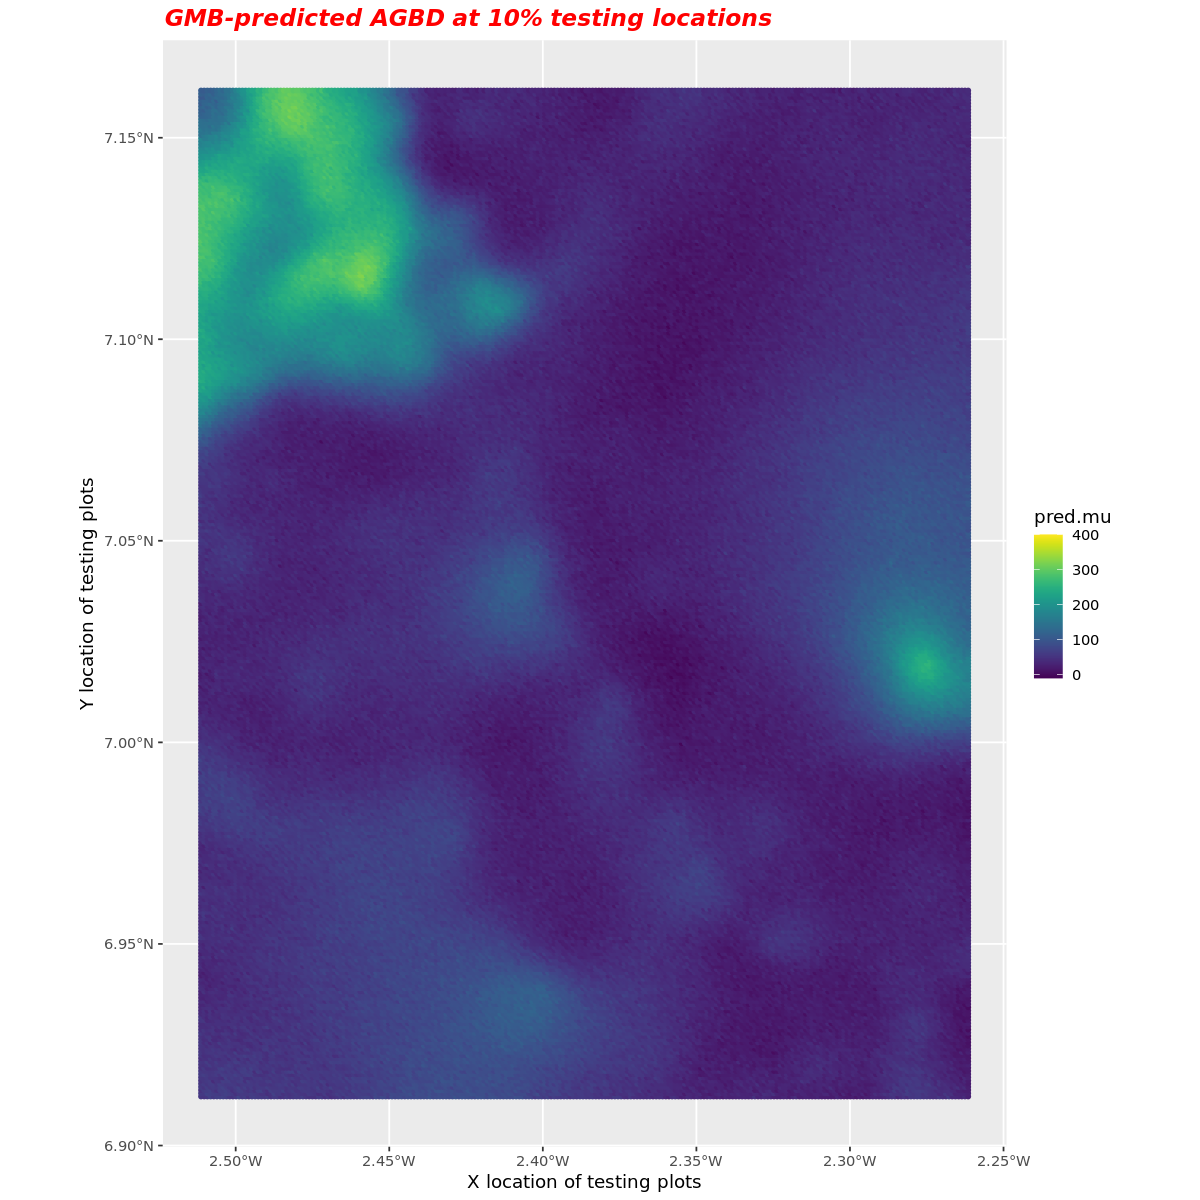

In [33]:
grid_to_predict = st_make_grid(Sudan, cellsize = c(100,100), what = "centers") %>% st_as_sf()
grid = as.data.frame(grid_to_predict %>% st_coordinates())

loc.plot_T <- data.matrix(as.data.frame(cbind(grid$X,grid$Y)))

samples = inla.posterior.sample(n = 200, result = model_fit) # Draw posterior samples from our model fit 
A.pred = inla.spde.make.A(mesh = mesh, loc = loc.plot_T) # Make a new projector matrix with the same mesh, but new plot locations 

# Our model function
pred_fun = function(...){
  drop(intercept + 
    A.pred%*%alpha.spat[1:k]) + 
    rnorm(nrow(A.pred), sd = sqrt(1/theta[1])) 
}

# Generate prediction samples, i.e. ask INLA to use the prediction function and samples to make predictions at our testing plot locations. 
pred.samples = (inla.posterior.sample.eval(fun = pred_fun,samples = samples)) #

# Model mean AGBD expectations and SD's at the grid locations
pred.mu = Matrix::rowMeans(pred.samples)
pred.sd = apply(pred.samples, 1, sd)
options(repr.plot.width=10, repr.plot.height=10)

####################### And here are some maps to see what the predictions look like at the plot locations ##########
ggplot() + coord_sf(crs = 6933) + 
           geom_point(aes(x = loc.plot_T[,1], y = loc.plot_T[,2], col = pred.mu),size=1) +  # make a map to see plot locations and the AGBD values at each location
           scale_color_viridis(limits = c(-10, 400)) + xlab("X location of testing plots") + ylab("Y location of testing plots") + ggtitle("GMB-predicted AGBD at 10% testing locations") + theme(plot.title = element_text(color="red", size=14, face="bold.italic"))
           # geom_sf(data = Deforestation,col="red",fill=NA,lwd=1)# add our fake deforestation sites

In [15]:
class(grid)

[1] "matrix" "array"

In [43]:
################## IMPROVING OUR MODEL ############

# Before we move ahead, let's try improve our model by making a finer mesh. We choose to rougly 2/3rds our max.edge (10 km) and see if our model improves. 

max.edge = 50
Sudan.buffer = st_buffer(Sudan, dist = max.edge*5) # We also make a 5 km buffer around Sudan to prevent boundary effects.
mesh = inla.mesh.2d(boundary = list(as(Sudan, "Spatial"), as(Sudan.buffer, "Spatial")), max.edge = c(max.edge, 3*max.edge), cutoff = 2*max.edge/3, offset = c(max.edge, 5*max.edge)) 
k = mesh$n ### This is the resulting number of vertices
loc.plot <- data.matrix(loc.plot) #In case loc.plot is a df rather than matrix, use "loc.plot <- data.matrix(loc.plot)"
n.plot = nrow(loc.plot)
A.plot = inla.spde.make.A(mesh = mesh, loc = loc.plot) # make a new projector matrix with the new mesh and the same plot locations. 
spde.alpha = inla.spde2.pcmatern(mesh, 
                                 prior.range = c(30000, 0.01), # This says the probability that the range is LESS than 30 km is 0.01
                                 prior.sigma = c(60, 0.01)) # This says the probability that the sd is GREATER than 60 Mg/ha is 0.01

# Priors for the varying coefficient beta_tilde
spde.beta = inla.spde2.pcmatern(mesh, 
                                prior.range = c(30000, 0.01), # Same interpretations here
                                prior.sigma = c(1, 0.5)) # This says the probability that the sd is GREATER than 1 is 0.5

### Construct our formula #####

### Construct our formula #####
formula = agbd ~
  -1 + # removes the automatic intercept so you can include your named intercept
  intercept + 
  f(alpha.spat, model = spde.alpha)
## Arrange our data so we can supply it to INLA to input in the formula above #####
stack = inla.stack(data = list(agbd = gedi.agbd),
                   A = list(1, 
                            A.plot),
                   effects = list(
                     intercept = rep(1, n.plot),
                     alpha.spat = 1:k)
                  )

# Below, notice the arguments in 'control.mode = ' We tell INLA our starting parameters in "theta=", but tell it to restart the optimization from 
# there (restart = T), using the outputs of model_fit generated previously. It will still take a while, but less than it would have if we started from scratch

model_fit_v2 = inla(formula = formula, # Provide the formula
                 family = 'gaussian', # We assume our data follows a Gaussian generalized linear model (GLM)
                 data = inla.stack.data(stack), # These line and the one below are simply how we feed INLA the stack.
                 control.predictor = list(A = inla.stack.A(stack)),
                 control.compute = list(config = T, dic = T, waic = T, cpo = T),
                 control.inla = list(int.strategy = "eb"), # EB just fixes the hyperparameters at their maximum posterior (like maximum likelihood, but accounting for priors) values. The other methods manually integrate across the range of possible values.
                 control.mode = list(theta = model_fit$mode$theta, restart = T), #Ask INLA to restart the model using the previous iteration
                 verbose = TRUE)
summary(model_fit_v2)
save(model_fit_v2, file = "/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/GMB_Test/INLA_model_DIRECT_v2.RData")
hist(model_fit_v2$cpo$pit, breaks = 20) 

# options(repr.plot.width=4, repr.plot.height=4)
# load("/projects/my-public-bucket/Data/NASA_CMS_2023/Sudan/RData_saves/INLA_model_fit_v2.RData")
# summary(model_fit_v2)
# hist(model_fit_v2$cpo$pit, breaks = 20) 

# We don't see a massive improvement in either the PIT distributions, the DIC or WAIC values. 
# We can conclude that using a max.edge of 10 km is sufficient and there is no further need to refine our mesh. 

Warning message:
“Removed 104 rows containing missing values or values outside the scale range
(`geom_point()`).”


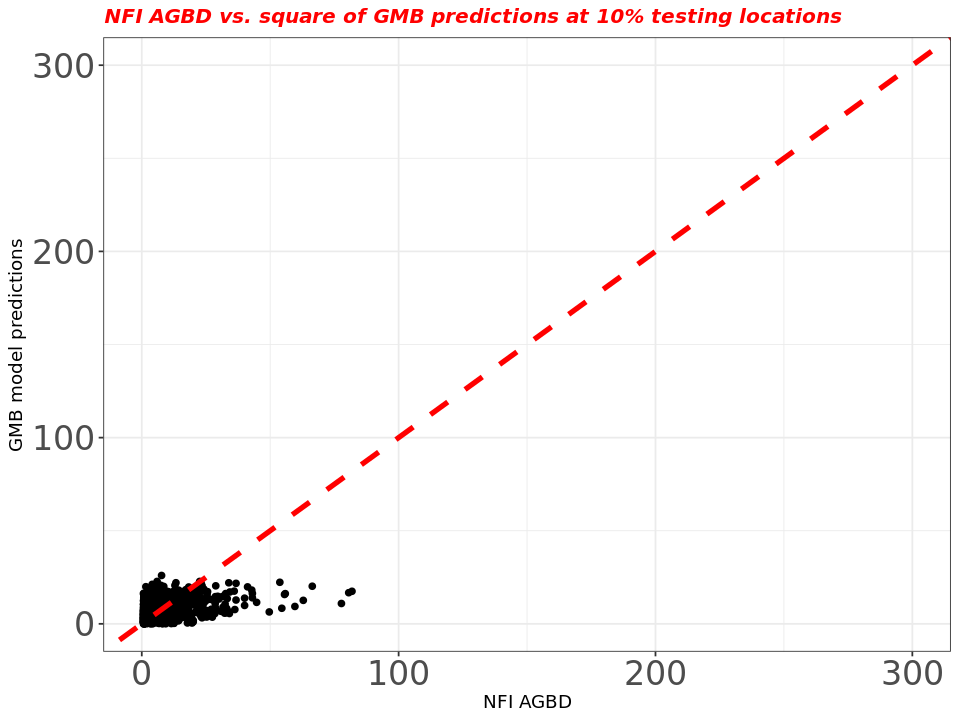

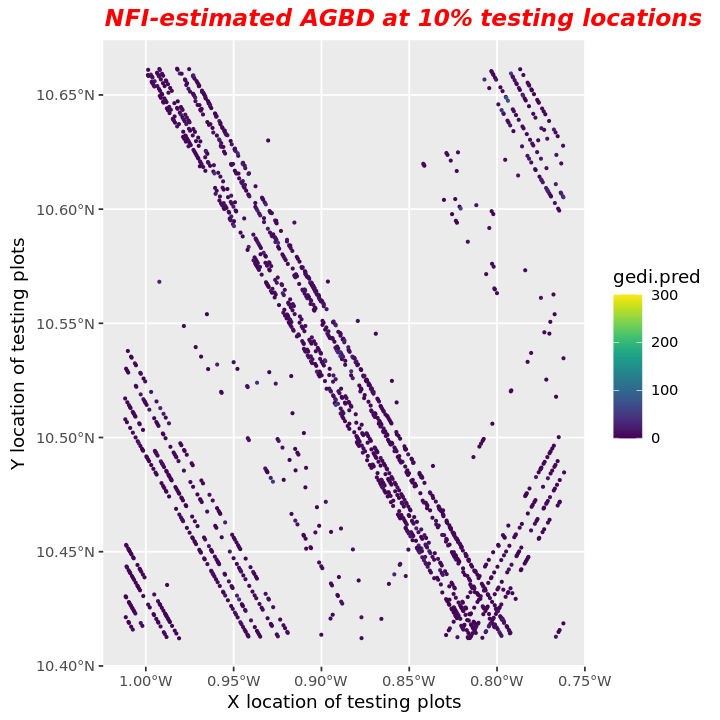

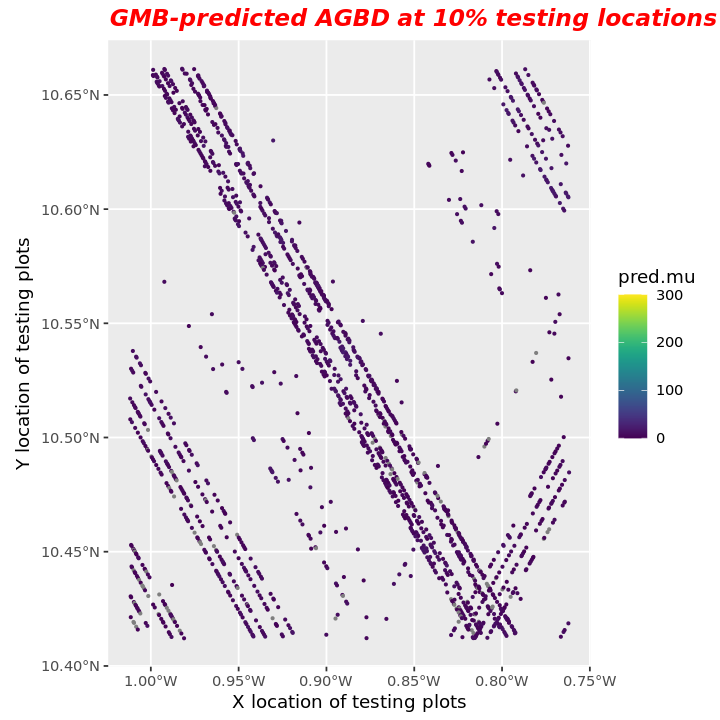

In [48]:
DATA_TEST <- read.csv("/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/GMB_Test/DATA_TEST.csv")

loc.plot_T <- data.matrix(as.data.frame(cbind(DATA_TEST$X,DATA_TEST$Y)))
gedi.pred <- (DATA_TEST$gedi.agbd)

samples = inla.posterior.sample(n = 250, result = model_fit_v2) # Draw posterior samples from our model fit 
A.pred = inla.spde.make.A(mesh = mesh, loc = loc.plot_T) # Make a new projector matrix with the same mesh, but new plot locations 

# Our model function
pred_fun = function(...){
  drop(intercept + 
    A.pred%*%alpha.spat[1:k]) + 
    rnorm(nrow(A.pred), sd = sqrt(1/theta[1])) 
}

# Generate prediction samples, i.e. ask INLA to use the prediction function and samples to make predictions at our testing plot locations. 
pred.samples = (inla.posterior.sample.eval(fun = pred_fun,samples = samples)) #

# Model mean AGBD expectations and SD's at the grid locations
pred.mu = Matrix::rowMeans(pred.samples)
pred.sd = apply(pred.samples, 1, sd)

# Let's also square the model expectations because we applied a sqrt transformation at the start
pred.mu = Matrix::rowMeans(pred.samples)
pred.sd = apply(pred.samples, 1, sd)

OUTPUT <- do.call(rbind, Map(data.frame, PRED=pred.mu, NFI=gedi.pred, PRED.SD=pred.sd, RES=gedi.pred-pred.mu))
options(repr.plot.width=8, repr.plot.height=6)
ggplot(data = OUTPUT, aes(x = NFI,y = PRED))+ geom_point()  + geom_abline(size=0.5,linetype=2,col="red",lwd=1.5) + theme_bw() + xlim(0,300) + ylim(0,300) + xlab("NFI AGBD") + ylab("GMB model predictions") + ggtitle("NFI AGBD vs. square of GMB predictions at 10% testing locations") + theme(plot.title = element_text(color="red", size=12, face="bold.italic"),axis.text=element_text(size=20))
        
####################### And here are some maps to see what the predictions look like at the plot locations ##########
options(repr.plot.width=6, repr.plot.height=6)
ggplot() + coord_sf(crs = 6933) + 
           geom_point(aes(x = loc.plot_T[,1], y = loc.plot_T[,2], col = gedi.pred),size=0.5) +  # make a map to see plot locations and the AGBD values at each location
           scale_color_viridis(limits = c(0, 300)) + xlab("X location of testing plots") + ylab("Y location of testing plots") + ggtitle("NFI-estimated AGBD at 10% testing locations") + theme(plot.title = element_text(color="red", size=14, face="bold.italic"))
           # geom_sf(data = Deforestation,col="red",fill=NA,lwd=1)# add our fake deforestation sites

ggplot() + coord_sf(crs = 6933) + 
           geom_point(aes(x = loc.plot_T[,1], y = loc.plot_T[,2], col = pred.mu),size=0.5) +  # make a map to see plot locations and the AGBD values at each location
           scale_color_viridis(limits = c(0, 300)) + xlab("X location of testing plots") + ylab("Y location of testing plots") + ggtitle("GMB-predicted AGBD at 10% testing locations") + theme(plot.title = element_text(color="red", size=14, face="bold.italic"))
           # geom_sf(data = Deforestation,col="red",fill=NA,lwd=1)# add our fake deforestation sites

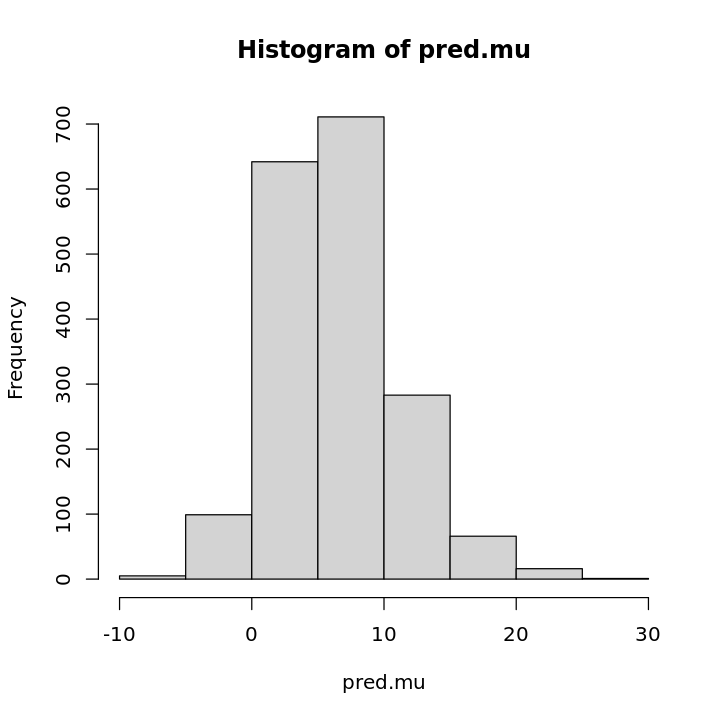

In [49]:
hist(pred.mu)